In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import pyedflib
import seaborn as sns
import statsmodels.api as sm
import mne
from scipy.signal import spectrogram

In [8]:
data = pd.read_csv(r"C:\Users\nico_\Desktop\INSERM\Projet ICEO\Recueil_ICEO_26012022_2.csv", sep=';', encoding='ISO-8859-1')

In [9]:
data.shape

(85, 107)

In [10]:
data.columns

Index(['Numéro', 'NOM Prénom', 'IPP', 'Date de naissance', 'Âge_années',
       'Sexe (1 = F ; 0 = M)', 'Poids (kg)', 'Taille (cm)', 'IMC (kg/m2)',
       'ASA',
       ...
       'Unnamed: 97', 'Unnamed: 98', 'Unnamed: 99', 'Unnamed: 100',
       'Unnamed: 101', 'Unnamed: 102', 'Unnamed: 103', 'Unnamed: 104',
       'Unnamed: 105', 'Unnamed: 106'],
      dtype='object', length=107)

In [11]:
data = data.loc[:, ["NOM Prénom","Âge_années", "Salle", "Date de recueil","Heure entrée en salle scope","Heure sortie de salle scope","Heure PROPOFOL induction","KETAMINE (mg)","Heure KETAMINE","Délai induction-IOT (s)","Burst-suppression (0/1)","Temps de suppression (sec)"]]

In [12]:
data.isna().sum()

NOM Prénom                      0
Âge_années                      0
Salle                           0
Date de recueil                 0
Heure entrée en salle scope     0
Heure sortie de salle scope     0
Heure PROPOFOL induction        0
KETAMINE (mg)                   0
Heure KETAMINE                  0
Délai induction-IOT (s)         0
Burst-suppression (0/1)         0
Temps de suppression (sec)     59
dtype: int64

In [13]:
data["Temps de suppression (sec)"].fillna(0, inplace=True)

In [14]:
data["Temps de suppression (sec)"].isna().sum()

0

In [15]:
data.duplicated().sum()

0

In [16]:
data_BO7 = data.loc[data['Salle'] == 7]


In [17]:
data_BO8 = data.loc[data['Salle'] == 8]

In [18]:
data_BO9 = data.loc[data['Salle'] == 9]

# BO7

In [19]:
import os
import re

eeg_path = r"C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL BO7\Du 251120 au 241021"

In [20]:
# Récupération des noms des sous-dossiers contenant les fichiers EEG
subdirs = [name for name in os.listdir(eeg_path) if os.path.isdir(os.path.join(eeg_path, name))]

In [21]:
subdirs

['Root_2000087745_20201125_114052',
 'Root_2000087745_20201125_121924',
 'Root_2000087745_20210204_111230',
 'Root_2000087745_20210204_112624',
 'Root_2000087745_20210210_135831',
 'Root_2000087745_20210211_083841',
 'Root_2000087745_20210211_084735',
 'Root_2000087745_20210212_083451',
 'Root_2000087745_20210219_083325',
 'Root_2000087745_20210223_083243',
 'Root_2000087745_20210223_083828',
 'Root_2000087745_20210223_150553',
 'Root_2000087745_20210301_083711',
 'Root_2000087745_20210308_134336',
 'Root_2000087745_20210311_091334',
 'Root_2000087745_20210315_114431',
 'Root_2000087745_20210316_130258',
 'Root_2000087745_20210317_151646',
 'Root_2000087745_20210324_115324',
 'Root_2000087745_20210329_121850',
 'Root_2000087745_20210401_071814',
 'Root_2000087745_20210401_145325',
 'Root_2000087745_20210402_094132',
 'Root_2000087745_20210402_141042',
 'Root_2000087745_20210408_142202',
 'Root_2000087745_20210415_123425',
 'Root_2000087745_20210507_073609',
 'Root_2000087745_20210511_1

In [22]:
eeg_files = [] # Liste pour stocker tous les fichiers EEG

for subdir in subdirs:
    eeg_dir = os.path.join(eeg_path, subdir) # Chemin du sous-dossier contenant les fichiers EEG
    for file in os.listdir(eeg_dir):
        if file.endswith(".edf"): # Vérifie si le fichier est un fichier EEG
            eeg_files.append(os.path.join(eeg_dir, file)) # Ajoute le chemin du fichier EEG à la liste


In [23]:
eeg_files

['C:\\Users\\nico_\\Desktop\\INSERM\\Projet ICEO\\ORL BO7\\Du 251120 au 241021\\Root_2000087745_20201125_114052\\EEG_201125_114052.edf',
 'C:\\Users\\nico_\\Desktop\\INSERM\\Projet ICEO\\ORL BO7\\Du 251120 au 241021\\Root_2000087745_20201125_121924\\EEG_201125_121924.edf',
 'C:\\Users\\nico_\\Desktop\\INSERM\\Projet ICEO\\ORL BO7\\Du 251120 au 241021\\Root_2000087745_20210204_111230\\EEG_210204_111231.edf',
 'C:\\Users\\nico_\\Desktop\\INSERM\\Projet ICEO\\ORL BO7\\Du 251120 au 241021\\Root_2000087745_20210204_112624\\EEG_210204_112624.edf',
 'C:\\Users\\nico_\\Desktop\\INSERM\\Projet ICEO\\ORL BO7\\Du 251120 au 241021\\Root_2000087745_20210204_112624\\EEG_210204_122612.edf',
 'C:\\Users\\nico_\\Desktop\\INSERM\\Projet ICEO\\ORL BO7\\Du 251120 au 241021\\Root_2000087745_20210210_135831\\EEG_210210_135832.edf',
 'C:\\Users\\nico_\\Desktop\\INSERM\\Projet ICEO\\ORL BO7\\Du 251120 au 241021\\Root_2000087745_20210210_135831\\EEG_210210_145820.edf',
 'C:\\Users\\nico_\\Desktop\\INSERM\\Proj

In [24]:
dates= []

for file_path in eeg_files:
    # Extraire la partie contenant la date (le deuxième élément après division par `_`)
    date_str = file_path.split('\\')[-1].split('_')[1]
    # Ajouter un placeholder pour le temps
    #date_str += '_000000'
    # Convertir la chaîne de date en objet datetime
    date_obj = pd.to_datetime(date_str, format='%y%m%d')#_%H%M%S')
    dates.append(date_obj)

In [25]:
dates

[Timestamp('2020-11-25 00:00:00'),
 Timestamp('2020-11-25 00:00:00'),
 Timestamp('2021-02-04 00:00:00'),
 Timestamp('2021-02-04 00:00:00'),
 Timestamp('2021-02-04 00:00:00'),
 Timestamp('2021-02-10 00:00:00'),
 Timestamp('2021-02-10 00:00:00'),
 Timestamp('2021-02-10 00:00:00'),
 Timestamp('2021-02-11 00:00:00'),
 Timestamp('2021-02-11 00:00:00'),
 Timestamp('2021-02-11 00:00:00'),
 Timestamp('2021-02-11 00:00:00'),
 Timestamp('2021-02-12 00:00:00'),
 Timestamp('2021-02-19 00:00:00'),
 Timestamp('2021-02-23 00:00:00'),
 Timestamp('2021-02-23 00:00:00'),
 Timestamp('2021-02-23 00:00:00'),
 Timestamp('2021-02-23 00:00:00'),
 Timestamp('2021-03-01 00:00:00'),
 Timestamp('2021-03-08 00:00:00'),
 Timestamp('2021-03-11 00:00:00'),
 Timestamp('2021-03-11 00:00:00'),
 Timestamp('2021-03-11 00:00:00'),
 Timestamp('2021-03-15 00:00:00'),
 Timestamp('2021-03-15 00:00:00'),
 Timestamp('2021-03-15 00:00:00'),
 Timestamp('2021-03-15 00:00:00'),
 Timestamp('2021-03-16 00:00:00'),
 Timestamp('2021-03-

In [26]:
heures = []
for file_path in eeg_files:
    # Extraire la partie contenant l'heure (le troisième élément après division par `_`)
    heure_str = file_path.split('\\')[-1].split('_')[2][:-4]
    
    # Convertir la chaîne d'heure en objet datetime
    heure_obj = pd.to_datetime(heure_str, format='%H%M%S')
    heures.append(heure_obj.time())
    
    
# file_path.split('\\') divise la chaîne file_path en une liste de sous-chaînes 
# en utilisant le caractère \ comme séparateur. Ensuite, [-1] récupère le dernier 
# élément de cette liste, qui correspondra au nom du fichier lui-même. Enfin, .split('_')[2] 
# divise cette chaîne de nom de fichier en une liste de sous-chaînes en utilisant le 
# caractère _ comme séparateur et récupère le troisième élément de cette liste (l'index 2).

# [:-4] à la fin de la ligne pour supprimer les 4 derniers caractères (l'extension .edf) du 
# troisième élément de la liste obtenue avec split('_').


In [27]:
heures

[datetime.time(11, 40, 52),
 datetime.time(12, 19, 24),
 datetime.time(11, 12, 31),
 datetime.time(11, 26, 24),
 datetime.time(12, 26, 12),
 datetime.time(13, 58, 32),
 datetime.time(14, 58, 20),
 datetime.time(15, 58, 8),
 datetime.time(8, 38, 41),
 datetime.time(8, 47, 36),
 datetime.time(9, 47, 24),
 datetime.time(10, 47, 12),
 datetime.time(8, 34, 51),
 datetime.time(8, 33, 26),
 datetime.time(8, 32, 44),
 datetime.time(8, 38, 28),
 datetime.time(9, 38, 16),
 datetime.time(15, 5, 54),
 datetime.time(8, 37, 12),
 datetime.time(13, 43, 36),
 datetime.time(9, 13, 34),
 datetime.time(10, 13, 22),
 datetime.time(11, 13, 10),
 datetime.time(11, 44, 32),
 datetime.time(12, 44, 20),
 datetime.time(13, 44, 8),
 datetime.time(14, 43, 56),
 datetime.time(13, 2, 59),
 datetime.time(15, 16, 47),
 datetime.time(16, 16, 35),
 datetime.time(11, 53, 24),
 datetime.time(12, 53, 12),
 datetime.time(13, 53),
 datetime.time(12, 18, 51),
 datetime.time(13, 18, 39),
 datetime.time(14, 18, 27),
 datetime.

In [28]:
df_BO7 = pd.DataFrame({'Date de recueil': dates, 'Heure de recueil' : heures, "Fichiers EEG" : eeg_files})

In [29]:
df_BO7

Date de recueil Heure de recueil  \
0        2020-11-25         11:40:52   
1        2020-11-25         12:19:24   
2        2021-02-04         11:12:31   
3        2021-02-04         11:26:24   
4        2021-02-04         12:26:12   
..              ...              ...   
193      2021-10-21         13:04:47   
194      2021-10-21         14:04:35   
195      2021-10-21         15:04:23   
196      2021-10-22         14:46:15   
197      2021-10-24         18:30:51   

                                          Fichiers EEG  
0    C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
1    C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
2    C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
3    C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
4    C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
..                                                 ...  
193  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
194  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
195  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
196  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
197  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  

[198 rows x 3 columns]

# df_BO7 Conversion Heure de recueil, objet to datetime

In [30]:
import datetime
from datetime import timedelta 

# Convertir la composante de temps en un objet timedelta
#timedelta_component = time_component.apply(lambda x: datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))

In [31]:
df_BO7['Heure de recueil'] = pd.to_datetime(df_BO7['Heure de recueil'], format='%H:%M:%S')
# df_BO7['TimeDelta'] = df_BO7['Heure de recueil'].apply(lambda x: datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))


In [32]:
df_BO7.dtypes

Date de recueil     datetime64[ns]
Heure de recueil    datetime64[ns]
Fichiers EEG                object
dtype: object

In [33]:
df_BO7.head()

Date de recueil    Heure de recueil  \
0      2020-11-25 1900-01-01 11:40:52   
1      2020-11-25 1900-01-01 12:19:24   
2      2021-02-04 1900-01-01 11:12:31   
3      2021-02-04 1900-01-01 11:26:24   
4      2021-02-04 1900-01-01 12:26:12   

                                        Fichiers EEG  
0  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
1  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
2  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
3  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
4  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...

In [34]:
# Sélectionner juste l'heure
df_BO7['Heure de recueil'] = df_BO7['Heure de recueil'].dt.time

In [35]:
df_BO7['Heure de recueil'] = pd.to_datetime(df_BO7['Heure de recueil'], format='%H:%M:%S')

In [36]:
df_BO7.dtypes

Date de recueil     datetime64[ns]
Heure de recueil    datetime64[ns]
Fichiers EEG                object
dtype: object

Test df_BO7 Date de receuil  et heure okay datetime64[ns]

# data_BO7 Conversion Heures, objet to datetime

In [37]:
data_BO7.dtypes

NOM Prénom                      object
Âge_années                       int64
Salle                            int64
Date de recueil                 object
Heure entrée en salle scope     object
Heure sortie de salle scope     object
Heure PROPOFOL induction        object
KETAMINE (mg)                    int64
Heure KETAMINE                  object
Délai induction-IOT (s)         object
Burst-suppression (0/1)         object
Temps de suppression (sec)     float64
dtype: object

# data_BO7["Heure entrée en salle scope"] 

In [38]:
data_BO7["Heure entrée en salle scope"] = pd.to_datetime(data_BO7["Heure entrée en salle scope"], format='%H:%M:%S')

C:\Users\nico_\AppData\Local\Temp\ipykernel_9992\1476382542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_BO7["Heure entrée en salle scope"] = pd.to_datetime(data_BO7["Heure entrée en salle scope"], format='%H:%M:%S')


In [39]:
data_BO7["Heure entrée en salle scope"] = data_BO7["Heure entrée en salle scope"].dt.time

C:\Users\nico_\AppData\Local\Temp\ipykernel_9992\1046862985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_BO7["Heure entrée en salle scope"] = data_BO7["Heure entrée en salle scope"].dt.time


In [40]:
data_BO7["Heure entrée en salle scope"] = pd.to_datetime(data_BO7["Heure entrée en salle scope"], format='%H:%M:%S')

C:\Users\nico_\AppData\Local\Temp\ipykernel_9992\1476382542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_BO7["Heure entrée en salle scope"] = pd.to_datetime(data_BO7["Heure entrée en salle scope"], format='%H:%M:%S')


# data_BO7["Heure sortie de salle scope"] 

In [41]:
data_BO7["Heure sortie de salle scope"] = pd.to_datetime(data_BO7["Heure sortie de salle scope"], format='%H:%M:%S')

C:\Users\nico_\AppData\Local\Temp\ipykernel_9992\2243283764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_BO7["Heure sortie de salle scope"] = pd.to_datetime(data_BO7["Heure sortie de salle scope"], format='%H:%M:%S')


In [42]:
data_BO7["Heure sortie de salle scope"] = data_BO7["Heure sortie de salle scope"].dt.time

C:\Users\nico_\AppData\Local\Temp\ipykernel_9992\3780338661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_BO7["Heure sortie de salle scope"] = data_BO7["Heure sortie de salle scope"].dt.time


In [43]:
data_BO7["Heure sortie de salle scope"] = pd.to_datetime(data_BO7["Heure sortie de salle scope"], format='%H:%M:%S')

C:\Users\nico_\AppData\Local\Temp\ipykernel_9992\2243283764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_BO7["Heure sortie de salle scope"] = pd.to_datetime(data_BO7["Heure sortie de salle scope"], format='%H:%M:%S')


In [44]:
data_BO7.dtypes

NOM Prénom                             object
Âge_années                              int64
Salle                                   int64
Date de recueil                        object
Heure entrée en salle scope    datetime64[ns]
Heure sortie de salle scope    datetime64[ns]
Heure PROPOFOL induction               object
KETAMINE (mg)                           int64
Heure KETAMINE                         object
Délai induction-IOT (s)                object
Burst-suppression (0/1)                object
Temps de suppression (sec)            float64
dtype: object

# data_BO7 Conversion Heures, objet to datetime

In [45]:
#data_BO7["Date de recueil "] = pd.to_datetime(data_BO7["Date de recueil"], format='%y%m%d')

data_BO7["Date de recueil"] = pd.to_datetime(data_BO7["Date de recueil"], format='%d/%m/%Y')


C:\Users\nico_\AppData\Local\Temp\ipykernel_9992\815408556.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_BO7["Date de recueil"] = pd.to_datetime(data_BO7["Date de recueil"], format='%d/%m/%Y')


In [46]:
# Convertir les objets datetime en chaînes de caractères avec le format 'YYYY-MM-DD'
#data_BO7["Date de recueil"] = data_BO7["Date de recueil"].dt.strftime('%Y-%m-%d')

# Convertir les dates en chaînes de caractères avec le format 'YYYY-MM-DD'
data_BO7["Date de recueil"] = pd.to_datetime(data_BO7["Date de recueil"], format="%d/%m/%Y").dt.strftime('%Y-%m-%d')


C:\Users\nico_\AppData\Local\Temp\ipykernel_9992\2026673517.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_BO7["Date de recueil"] = pd.to_datetime(data_BO7["Date de recueil"], format="%d/%m/%Y").dt.strftime('%Y-%m-%d')


In [47]:
data_BO7["Date de recueil"] = pd.to_datetime(data_BO7["Date de recueil"])

C:\Users\nico_\AppData\Local\Temp\ipykernel_9992\2508514362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_BO7["Date de recueil"] = pd.to_datetime(data_BO7["Date de recueil"])


In [48]:
data_BO7.dtypes

NOM Prénom                             object
Âge_années                              int64
Salle                                   int64
Date de recueil                datetime64[ns]
Heure entrée en salle scope    datetime64[ns]
Heure sortie de salle scope    datetime64[ns]
Heure PROPOFOL induction               object
KETAMINE (mg)                           int64
Heure KETAMINE                         object
Délai induction-IOT (s)                object
Burst-suppression (0/1)                object
Temps de suppression (sec)            float64
dtype: object

# Analyse

# DELAHAYE Matthis

In [49]:
d2 = data_BO7.loc[data_BO7["NOM Prénom"] == "DELAHAYE Matthis"]
d2

NOM Prénom  Âge_années  Salle Date de recueil  \
34  DELAHAYE Matthis          20      7      2021-10-12   

   Heure entrée en salle scope Heure sortie de salle scope  \
34         1900-01-01 09:30:00         1900-01-01 13:23:00   

   Heure PROPOFOL induction  KETAMINE (mg) Heure KETAMINE  \
34                    09:33             15          10:00   

   Délai induction-IOT (s) Burst-suppression (0/1)  Temps de suppression (sec)  
34                     565                       0                         0.0

In [50]:
df_selection2 = df_BO7.loc[df_BO7['Date de recueil'] == '2021-10-12']
df_selection2

Date de recueil    Heure de recueil  \
183      2021-10-12 1900-01-01 09:26:55   
184      2021-10-12 1900-01-01 10:26:43   
185      2021-10-12 1900-01-01 11:26:31   
186      2021-10-12 1900-01-01 12:26:19   
187      2021-10-12 1900-01-01 13:41:18   
188      2021-10-12 1900-01-01 14:41:06   

                                          Fichiers EEG  
183  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
184  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
185  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
186  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
187  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
188  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...

In [51]:
i2 = df_selection2.loc[[183,184,185,186]]
i2

Date de recueil    Heure de recueil  \
183      2021-10-12 1900-01-01 09:26:55   
184      2021-10-12 1900-01-01 10:26:43   
185      2021-10-12 1900-01-01 11:26:31   
186      2021-10-12 1900-01-01 12:26:19   

                                          Fichiers EEG  
183  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
184  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
185  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...  
186  C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL ...

# 183

In [52]:
lien_eeg_complets183 = i2["Fichiers EEG"].loc[[183]].to_string(index=False)
print(lien_eeg_complets183)

C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL B...


In [53]:
path_to_edf_file = r"C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL BO7\Du 251120 au 241021\Root_2000087745_20211012_092655\EEG_211012_092655.edf"

raw_data = mne.io.read_raw_edf(path_to_edf_file)

data = raw_data.get_data()

df1 = pd.DataFrame(data.transpose()*10**6, columns=raw_data.ch_names)  

Fs = raw_data.info['sfreq']
time_vec = np.arange(raw_data.n_times) / Fs

df1['Time'] = time_vec
last_col = df1.pop(df1.columns[-1])
df1.insert(0, last_col.name, last_col)

Extracting EDF parameters from C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL BO7\Du 251120 au 241021\Root_2000087745_20211012_092655\EEG_211012_092655.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


# 184

In [54]:
lien_eeg_complets184 = i2["Fichiers EEG"].loc[[184]].to_string(index=False)
print(lien_eeg_complets184)

C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL B...


In [55]:
path_to_edf_file = r"C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL BO7\Du 251120 au 241021\Root_2000087745_20211012_092655\EEG_211012_102643.edf"

raw_data = mne.io.read_raw_edf(path_to_edf_file)

data = raw_data.get_data()

df2 = pd.DataFrame(data.transpose()*10**6, columns=raw_data.ch_names)  

Fs = raw_data.info['sfreq']
time_vec = np.arange(raw_data.n_times) / Fs

df2['Time'] = time_vec
last_col = df2.pop(df2.columns[-1])
df2.insert(0, last_col.name, last_col)

Extracting EDF parameters from C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL BO7\Du 251120 au 241021\Root_2000087745_20211012_092655\EEG_211012_102643.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


# 185

In [56]:
lien_eeg_complets185 = i2["Fichiers EEG"].loc[[185]].to_string(index=False)
print(lien_eeg_complets185)

C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL B...


In [57]:
path_to_edf_file = r"C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL BO7\Du 251120 au 241021\Root_2000087745_20211012_092655\EEG_211012_112631.edf"

raw_data = mne.io.read_raw_edf(path_to_edf_file)

data = raw_data.get_data()

df3 = pd.DataFrame(data.transpose()*10**6, columns=raw_data.ch_names)  

Fs = raw_data.info['sfreq']
time_vec = np.arange(raw_data.n_times) / Fs

df3['Time'] = time_vec
last_col = df3.pop(df3.columns[-1])
df3.insert(0, last_col.name, last_col)

Extracting EDF parameters from C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL BO7\Du 251120 au 241021\Root_2000087745_20211012_092655\EEG_211012_112631.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


# 186

In [58]:
lien_eeg_complets186 = i2["Fichiers EEG"].loc[[186]].to_string(index=False)
print(lien_eeg_complets186)

C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL B...


In [59]:
path_to_edf_file = r"C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL BO7\Du 251120 au 241021\Root_2000087745_20211012_092655\EEG_211012_122619.edf"

raw_data = mne.io.read_raw_edf(path_to_edf_file)

data = raw_data.get_data()

df4 = pd.DataFrame(data.transpose()*10**6, columns=raw_data.ch_names)  

Fs = raw_data.info['sfreq']
time_vec = np.arange(raw_data.n_times) / Fs

df4['Time'] = time_vec
last_col = df4.pop(df4.columns[-1])
df4.insert(0, last_col.name, last_col)

Extracting EDF parameters from C:\Users\nico_\Desktop\INSERM\Projet ICEO\ORL BO7\Du 251120 au 241021\Root_2000087745_20211012_092655\EEG_211012_122619.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [60]:
# Ajout de la durée de chaque DataFrame aux valeurs de "Time"
df2['Time'] = df2['Time'] + df1.iloc[-1]['Time']
df3['Time'] = df3['Time'] + df2.iloc[-1]['Time']
df4['Time'] = df4['Time'] + df3.iloc[-1]['Time']

In [61]:
# Concaténation des DataFrames en utilisant la colonne "Time" comme clé
df = pd.concat([df1, df2, df3, df4], axis=0, join='outer')

In [62]:
# Tri des données par ordre croissant de la colonne "Time"
df = df.sort_values(by='Time')

In [63]:
# Réindexation des lignes
df = df.reset_index(drop=True)

In [64]:
from scipy import signal

nperseg = int(1.5 * Fs)  
noverlap = int(nperseg / 3)
window = 'hann'  

# Calcul du spectrogramme pour la première colonne de votre DataFrame
frequencies, times, Sxx = signal.spectrogram(df[df.columns[1]], fs=Fs, nperseg=nperseg, noverlap=noverlap, window=window)

# Recherche des indices correspondant aux fréquences alpha et bêta
freq_indices_alpha = np.where((frequencies >= 8) & (frequencies <= 13))[0]
freq_indices_beta = np.where((frequencies >= 13) & (frequencies <= 25))[0]

# Extraction des puissances pour les fréquences sélectionnées
power_alpha = np.mean(Sxx[freq_indices_alpha, :], axis=0)
power_beta = np.mean(Sxx[freq_indices_beta, :], axis=0)


# Ajout d'une petite valeur constante pour éviter les divisions par zéro
power_alpha = power_alpha + 1e-10
power_beta = power_beta + 1e-10


# Conversion des puissances en décibels par hertz
power_db_alpha = 10 * np.log10(power_alpha)
power_db_beta = 10 * np.log10(power_beta)


# Création du DataFrame
df_spectrogram = pd.DataFrame({'temps': times, 'puissance_alpha': power_db_alpha, 'puissance_beta': power_db_beta})

# Seulement courbes alpha et beta

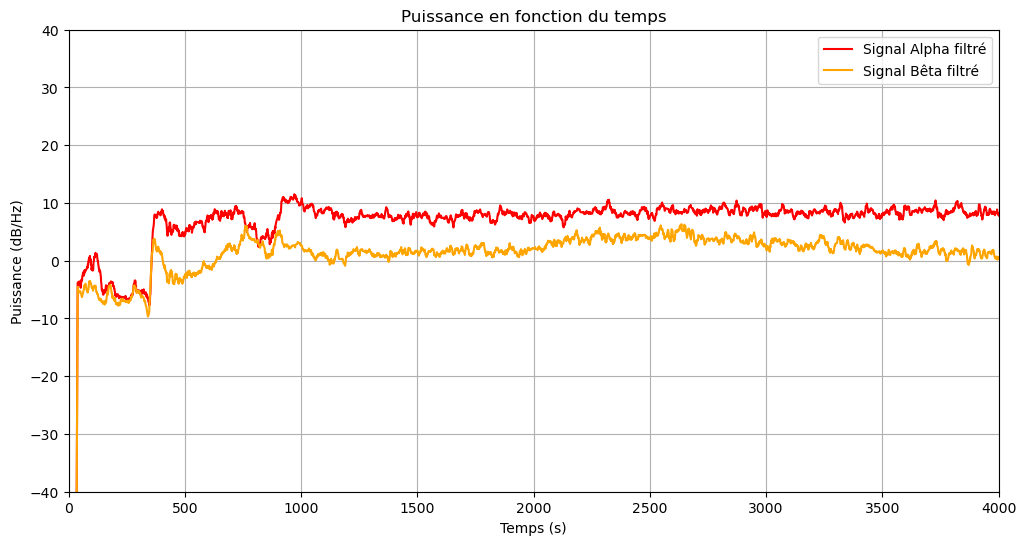

In [65]:
from scipy.signal import savgol_filter

# 1. Médiane glissante
median_alpha = df_spectrogram['puissance_alpha'].rolling(window=50, center=True).median()
median_beta = df_spectrogram['puissance_beta'].rolling(window=50, center=True).median()

# 2. Calcul des percentiles Q3 et Q1 glissants
q3_alpha = df_spectrogram['puissance_alpha'].rolling(window=50, center=True).quantile(0.75)
q1_alpha = df_spectrogram['puissance_alpha'].rolling(window=50, center=True).quantile(0.25)

q3_beta = df_spectrogram['puissance_beta'].rolling(window=50, center=True).quantile(0.75)
q1_beta = df_spectrogram['puissance_beta'].rolling(window=50, center=True).quantile(0.25)

# 3. Détermination du seuil
m_alpha = 2.5 * np.maximum(np.abs(median_alpha - q3_alpha), np.abs(median_alpha - q1_alpha))
m_beta = 2.5 * np.maximum(np.abs(median_beta - q3_beta), np.abs(median_beta - q1_beta))

# 4. Masque des outliers
mask_alpha = np.abs(df_spectrogram['puissance_alpha'] - median_alpha) > m_alpha
mask_alpha = mask_alpha.astype(int)

mask_beta = np.abs(df_spectrogram['puissance_beta'] - median_beta) > m_beta
mask_beta = mask_beta.astype(int)

# 5. Dilatation du masque
mask_alpha = pd.Series(mask_alpha).rolling(5, min_periods=1, center=True).max()
mask_beta = pd.Series(mask_beta).rolling(5, min_periods=1, center=True).max()

# 6. Remplacer les régions où le masque vaut 1 par la valeur médiane
cleaned_signal_alpha = df_spectrogram['puissance_alpha'].where(mask_alpha == 0, median_alpha)
cleaned_signal_beta = df_spectrogram['puissance_beta'].where(mask_beta == 0, median_beta)

# Filtre Savitzky-Golay sur le signal nettoyé
window_length = 11
poly_order = 1
filtered_signal_alpha = savgol_filter(cleaned_signal_alpha, window_length, poly_order)
filtered_signal_beta = savgol_filter(cleaned_signal_beta, window_length, poly_order)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

ax.plot(df_spectrogram['temps'], filtered_signal_alpha, color="red", label='Signal Alpha filtré')
ax.plot(df_spectrogram['temps'], filtered_signal_beta, color="orange", label='Signal Bêta filtré')
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Puissance (dB/Hz)')
ax.set_title('Puissance en fonction du temps')
ax.set_xlim(0,4000)
ax.grid(True)

# Ajouter des flèches verticales en bas du graphique avec des mots
#arrow_props = dict(arrowstyle='->')
#fleche1 = 580
#fleche2 = 1060
#fleche3 = 2920
#ax.annotate('Propofol', xy=(fleche1, -20), xytext=(fleche1+20, -30), arrowprops=arrow_props)
#ax.annotate('Intubation', xy=(fleche2, -20), xytext=(fleche2+20, -30), arrowprops=arrow_props)
#ax.annotate('Kétamine', xy=(fleche3, -20), xytext=(fleche3+20, -30), arrowprops=arrow_props)

ax.set_ylim(-40, 40)

#ax.axvline(x=fleche1, color='b', linestyle='--', linewidth=1)
#ax.axvline(x=fleche2, color='b', linestyle='--', linewidth=1)
#ax.axvline(x=fleche3, color='b', linestyle='--', linewidth=1)

ax.legend()
plt.show()


In [67]:
# Ajouter les tableaux filtered_signal_alpha et filtered_signal_beta comme colonnes dans df_spectrogram
df_spectrogram['filtered_signal_alpha'] = filtered_signal_alpha
df_spectrogram['filtered_signal_beta'] = filtered_signal_beta

# Définir les limites de la plage temporelle en secondes
temps_debut = 300.0
temps_fin = temps_debut + 700.0

# Filtrer les lignes du DataFrame en fonction de la plage temporelle
df_filtre = df_spectrogram[(df_spectrogram['temps'] >= temps_debut) & (df_spectrogram['temps'] <= temps_fin)]

# Trouver la valeur maximale de puissance_alpha dans la plage temporelle
valeur_max_alpha = df_filtre['filtered_signal_alpha'].max()
valeur_max_beta = df_filtre['filtered_signal_beta'].max()

# Afficher la valeur maximale
print("Valeur maximale de puissance_alpha : ", valeur_max_alpha)
print("Valeur maximale de puissance_beta : ", valeur_max_beta)


Valeur maximale de puissance_alpha :  11.501091249267258
Valeur maximale de puissance_beta :  5.994895337795991


# Visualisation EEG

Text(0.5, 0, 'Time')

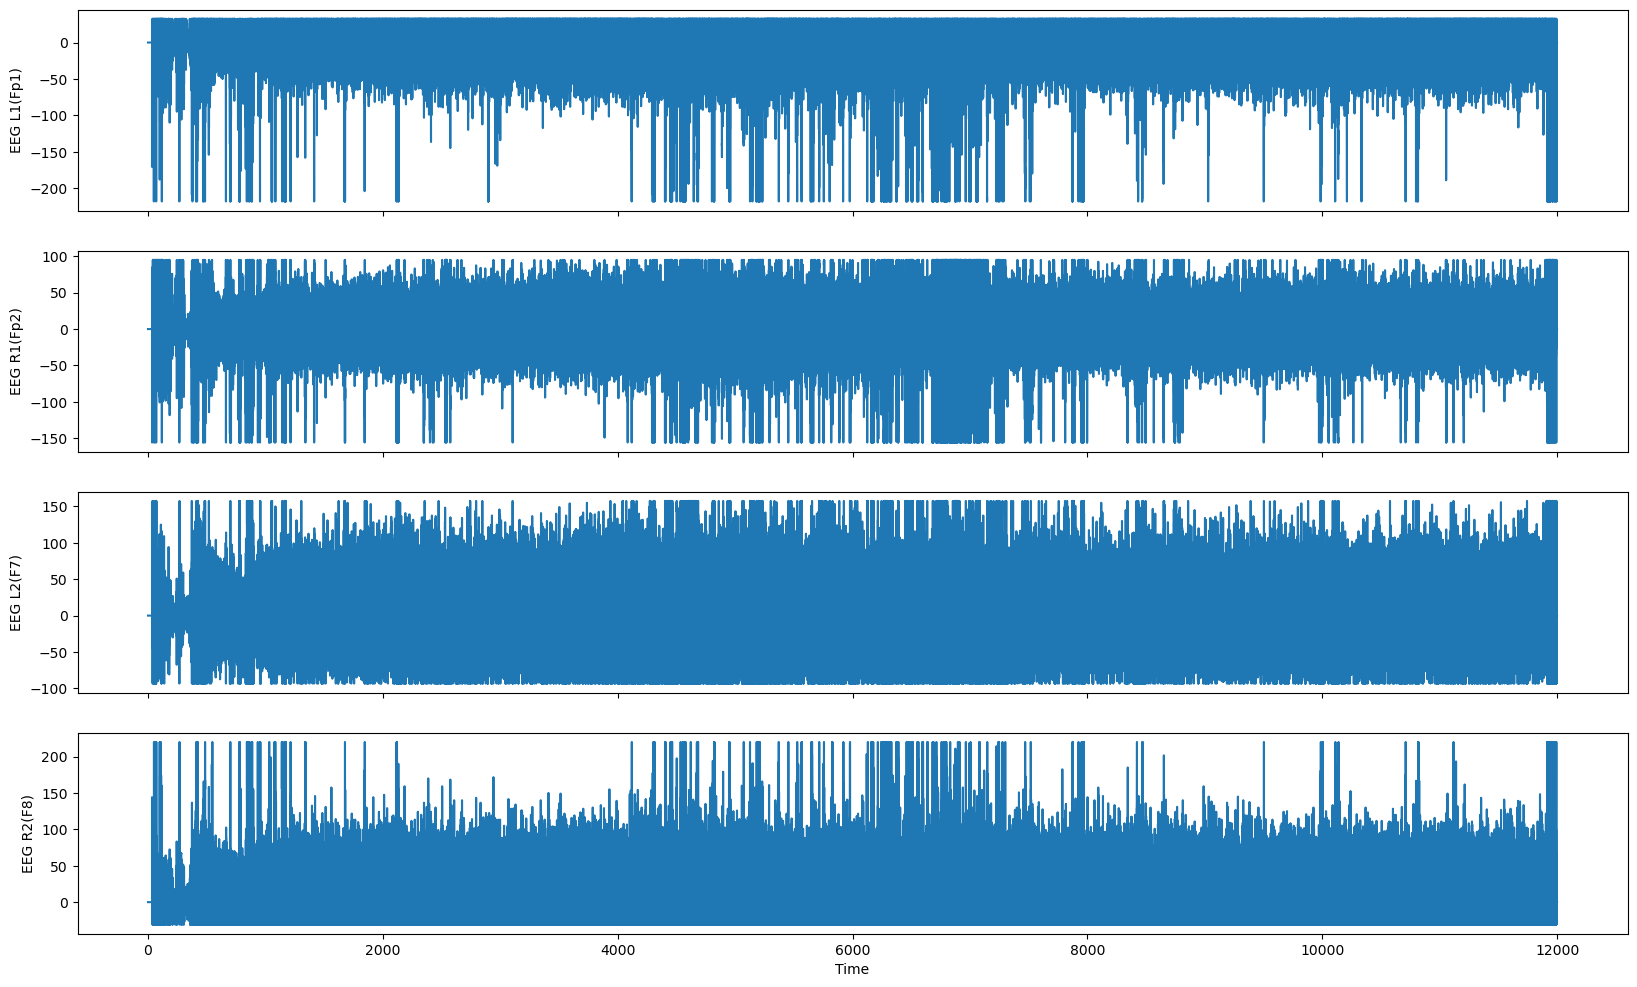

In [68]:
# Create a subplot with 4 rows
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20, 12), sharex=True)

# Iterate over each signal and plot it
for i, col in enumerate(df.columns[1:]):  # Par exemple, si les noms de colonnes de df sont ['Time', 'Signal1', 'Signal2', 'Signal3'], la boucle for commencera par col = 'Signal1' avec i = 0, puis col = 'Signal2' avec i = 1, etc.
    axs[i].plot(df['Time'], df[col])
    axs[i].set_ylabel(col) #  Cette instruction ajoute un label pour l'axe des ordonnées de chaque sous-figure créée dans la boucle for. Le label est défini par le nom de la colonne correspondant au signal, stocké dans la variable col.
# Add x and y axis labels
axs[-1].set_xlabel('Time')

# Spectrogramme

Text(0.5, 0, 'Time')

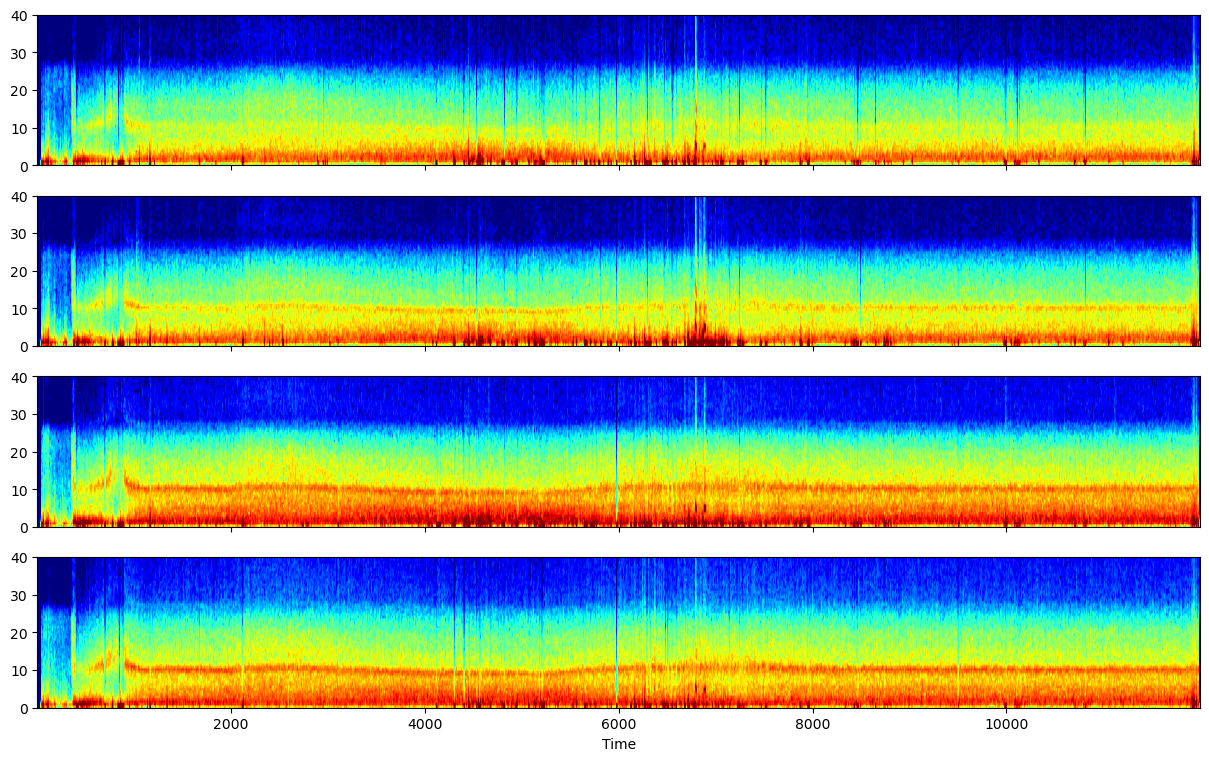

In [69]:
nperseg = int(1.5*Fs) # Petit reglage perso
noverlap = int(nperseg/3)
window = 'hann'  # type of window
# Iterate over each signal and plot its spectrogram in a separate subplot
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15, 9))
for i, col in enumerate(df.columns[1:]):
    pxx, freqs, bins, im = ax[i].specgram(df[col],
                                          Fs = Fs, # la fréquence d'échantillonnage du signal.
                                          NFFT = int(nperseg), # nombre de points à utiliser pour le calcul de la Transformée de Fourier Rapide (FFT). Cela détermine la résolution en fréquence du spectrogramme.
                                          mode= 'psd', # le type de spectre à calculer. Dans ce cas, 'psd' signifie densité spectrale de puissance.
                                          cmap= 'jet', # la carte de couleurs à utiliser pour représenter l'amplitude du spectre
                                          noverlap = int(noverlap)) # le nombre de points de recouvrement entre chaque segment de signal. Cela détermine la qualité de la résolution temporelle du spectrogramme.
    im.set_clim(-20,25)
    axs[i].pcolormesh(bins, freqs, pxx, cmap='coolwarm')
    axs[i].set_ylabel(col)
    ax[i].set_ylim(0, 40)  # y-axis limite à 40 dB
    
ax[-1].set_xlabel('Time')

#for i in range(len(ax)):
    #ax[i].axvline(x=250, color='w', linestyle='--')
    #ax[i].axvline(x=850, color='g', linestyle='--')
    #ax[i].axvline(x= 1700, color='r', linestyle='--')

# - Avant kétamine 

Text(0.5, 1.0, 'avant kétamine')

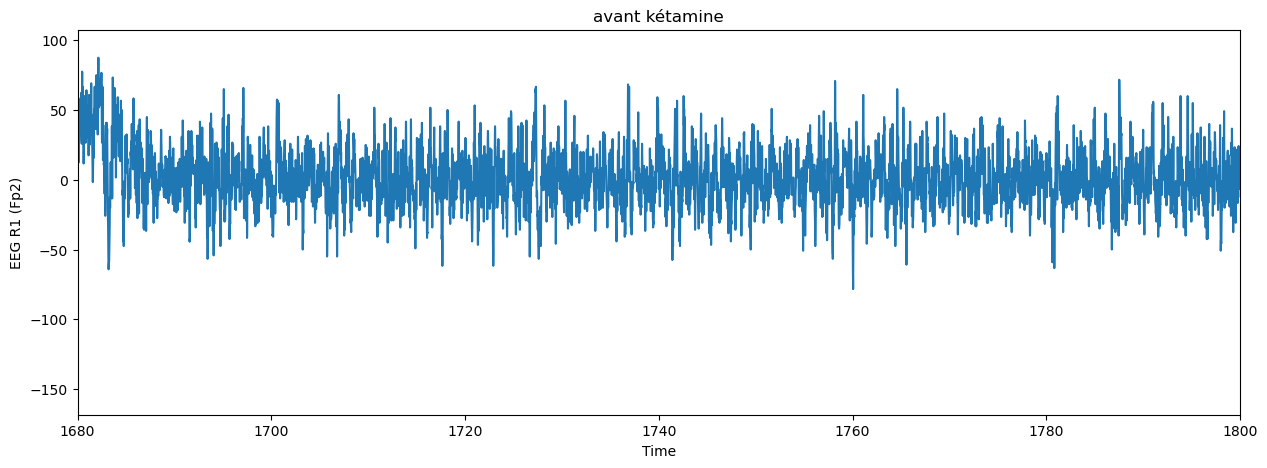

In [72]:
# Create a subplot
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the "EEG R1 (Fp2)" signal
ax.plot(df['Time'], df['EEG R1(Fp2)'])
ax.set_ylabel('EEG R1 (Fp2)')

# Add x and y axis labels
ax.set_xlabel('Time')
ax.set_xlim([1680, 1800])
ax.set_title("avant kétamine")

In [71]:
raw_data

<RawEDF | EEG_211012_122619.edf, 4 x 110010 (1235.0 s), ~8 kB, data not loaded>

# SEF95

Text(0.5, 1.0, 'SEF95 avant kétamine')

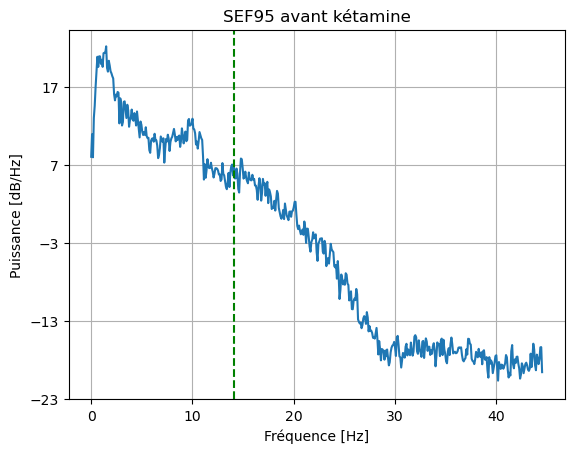

In [73]:
# Obtenir les données du signal et la fréquence d'échantillonnage
x = df['EEG R1(Fp2)'][int(1680*89.08):int(1800*89.08)]
Fs = 89.08 

# Calculer la transformée de Fourier du signal
X = np.fft.fft(x)

# Calculer la plage de fréquence
N = len(x)
f = np.linspace(0, Fs/2, N//2 + 1)

# Afficher la densité spectrale de puissance (PSD)
fig, ax = plt.subplots()
psd, freqs = ax.psd(x, NFFT=1024, Fs=Fs, window=np.hanning(1024), detrend='linear', noverlap=512, scale_by_freq=True)

# Calculer la SEF95
total_power = np.sum(psd)
cumulative_power = np.cumsum(psd)
sef95_idx = np.where(cumulative_power >= 0.95 * total_power)[0][0]
sef95_freq = freqs[sef95_idx]

# Afficher la SEF95
ax.axvline(sef95_freq, color='green', linestyle='--')


# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel('Puissance [dB/Hz]')
ax.set_title('SEF95 avant kétamine')

In [74]:
print(f"SEF95 = {sef95_freq:.2f} Hz")

SEF95 = 14.09 Hz


# Delta

Text(0.5, 1.0, 'Onde delta avant kétamine')

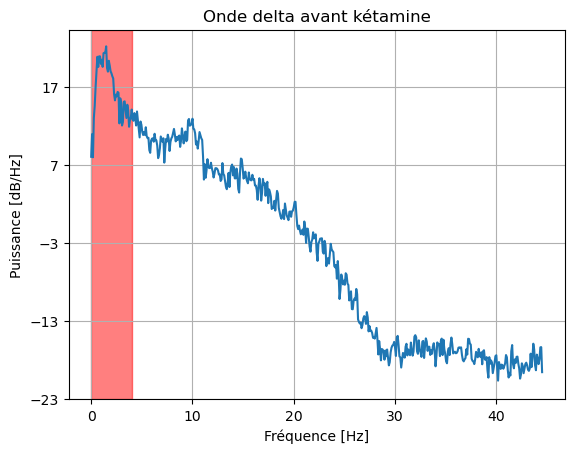

In [75]:
# Obtenir les données du signal et la fréquence d'échantillonnage
x = df['EEG R1(Fp2)'][int(1680*89.08):int(1800*89.08)]
Fs = 89.08 

# Calculer la transformée de Fourier du signal
X = np.fft.fft(x)

# Calculer la plage de fréquence
N = len(x)
f = np.linspace(0, Fs/2, N//2 + 1)

# Afficher la densité spectrale de puissance (PSD)
fig, ax = plt.subplots()
psd, freqs = ax.psd(x, NFFT=1024, Fs=Fs, window=np.hanning(1024), detrend='linear', noverlap=512, scale_by_freq=True)

# Identifier la bande alpha (8-13 Hz)
delta_start = 0.0
delta_end = 4.0
idx_delta = np.where((freqs >= delta_start) & (freqs <= delta_end))[0]

# Calculer la puissance alpha moyenne
delta_power = np.mean(psd[idx_delta])

# Afficher la bande alpha
ax.axvspan(delta_start, delta_end, alpha = 0.5, color='red')

# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel('Puissance [dB/Hz]')
ax.set_title('Onde delta avant kétamine')

In [76]:
print("Puissance delta moyenne : {:.2f} dB/Hz".format(delta_power))

Puissance delta moyenne : 60.15 dB/Hz


# Thêta   

Text(0.5, 1.0, 'Onde theta avant kétamine')

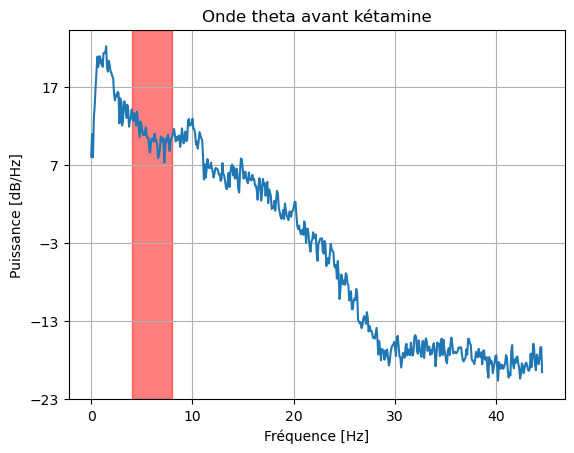

In [77]:
# Obtenir les données du signal et la fréquence d'échantillonnage
x = df['EEG R1(Fp2)'][int(1680*89.08):int(1800*89.08)]
Fs = 89.08 

# Calculer la transformée de Fourier du signal
X = np.fft.fft(x)

# Calculer la plage de fréquence
N = len(x)
f = np.linspace(0, Fs/2, N//2 + 1)

# Afficher la densité spectrale de puissance (PSD)
fig, ax = plt.subplots()
psd, freqs = ax.psd(x, NFFT=1024, Fs=Fs, window=np.hanning(1024), detrend='linear', noverlap=512, scale_by_freq=True)

# Identifier la bande alpha (8-13 Hz)
theta_start = 4.0
theta_end = 8.0
idx_theta = np.where((freqs >= theta_start) & (freqs <= theta_end))[0]

# Calculer la puissance alpha moyenne
theta_power = np.mean(psd[idx_theta])

# Afficher la bande alpha
ax.axvspan(theta_start, theta_end, alpha = 0.5, color='red')

# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel('Puissance [dB/Hz]')
ax.set_title('Onde theta avant kétamine')

In [78]:
print("Puissance theta moyenne : {:.2f} dB/Hz".format(theta_power))

Puissance theta moyenne : 12.52 dB/Hz


# Alpha

Text(0.5, 1.0, 'Onde alpha avant kétamine')

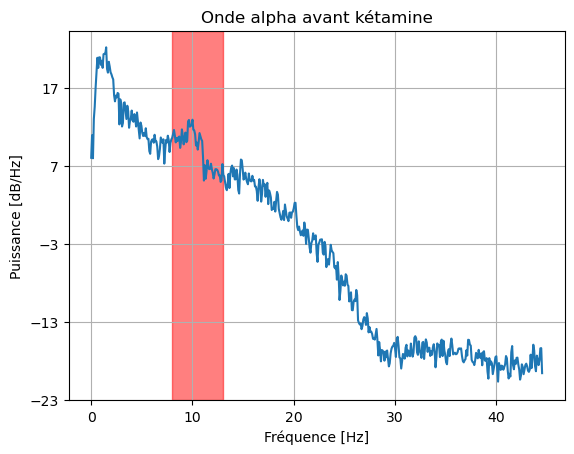

In [79]:
# Obtenir les données du signal et la fréquence d'échantillonnage
x = df['EEG R1(Fp2)'][int(1680*89.08):int(1800*89.08)]
Fs = 89.08 

# Calculer la transformée de Fourier du signal
X = np.fft.fft(x)

# Calculer la plage de fréquence
N = len(x)
f = np.linspace(0, Fs/2, N//2 + 1)

# Afficher la densité spectrale de puissance (PSD)
fig, ax = plt.subplots()
psd, freqs = ax.psd(x, NFFT=1024, Fs=Fs, window=np.hanning(1024), detrend='linear', noverlap=512, scale_by_freq=True)

# Identifier la bande alpha (8-13 Hz)
alpha_start = 8.0
alpha_end = 13.0
idx_alpha = np.where((freqs >= alpha_start) & (freqs <= alpha_end))[0]

# Calculer la puissance alpha moyenne
alpha_power = np.mean(psd[idx_alpha])

# Afficher la bande alpha
ax.axvspan(alpha_start, alpha_end, alpha=0.5, color='red')

# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel('Puissance [dB/Hz]')
ax.set_title('Onde alpha avant kétamine')

In [80]:
print("Puissance alpha moyenne : {:.2f} dB/Hz".format(alpha_power))

Puissance alpha moyenne : 9.33 dB/Hz


# Beta 

Text(0.5, 1.0, 'Onde beta avant kétamine')

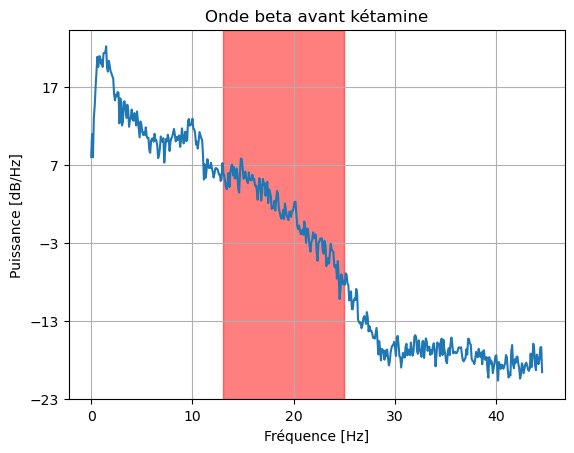

In [81]:
# Obtenir les données du signal et la fréquence d'échantillonnage
x = df['EEG R1(Fp2)'][int(1680*89.08):int(1800*89.08)]

# Calculer la transformée de Fourier du signal
X = np.fft.fft(x)

# Calculer la plage de fréquence
N = len(x)
f = np.linspace(0, Fs/2, N//2 + 1)

# Afficher la densité spectrale de puissance (PSD)
fig, ax = plt.subplots()
psd, freqs = ax.psd(x, NFFT=1024, Fs=Fs, window=np.hanning(1024), detrend='linear', noverlap=512, scale_by_freq=True)

# Identifier la bande alpha (8-13 Hz)
beta_start = 13.0
beta_end = 25.0
idx_beta = np.where((freqs >= beta_start) & (freqs <= beta_end))[0]

# Calculer la puissance alpha moyenne
beta_power = np.mean(psd[idx_beta])

# Afficher la bande alpha
ax.axvspan(beta_start, beta_end, alpha=0.5, color='red')

# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel('Puissance [dB/Hz]')
ax.set_title('Onde beta avant kétamine')

In [82]:
print("Puissance beta moyenne : {:.2f} dB/Hz".format(beta_power))

Puissance beta moyenne : 1.78 dB/Hz


# Gamma 

Text(0.5, 1.0, 'Onde gamma avant kétamine')

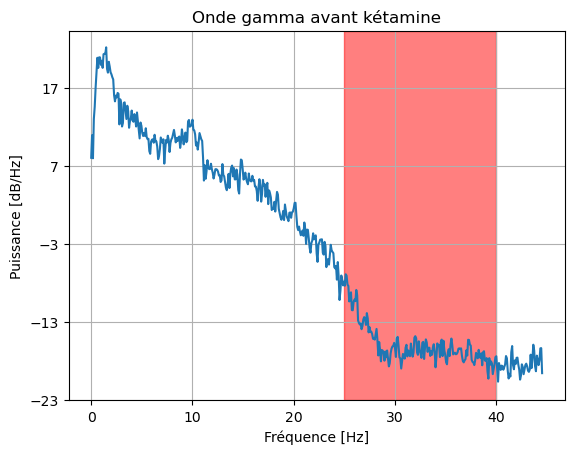

In [83]:
# Obtenir les données du signal et la fréquence d'échantillonnage
x = df['EEG R1(Fp2)'][int(1680*89.08):int(1800*89.08)]
Fs = 89.08 

# Calculer la transformée de Fourier du signal
X = np.fft.fft(x)

# Calculer la plage de fréquence
N = len(x)
f = np.linspace(0, Fs/2, N//2 + 1)

# Afficher la densité spectrale de puissance (PSD)
fig, ax = plt.subplots()
psd, freqs = ax.psd(x, NFFT=1024, Fs=Fs, window=np.hanning(1024), detrend='linear', noverlap=512, scale_by_freq=True)

# Identifier la bande alpha (8-13 Hz)
gamma_start = 25.0
gamma_end = 40.0
idx_gamma = np.where((freqs >= gamma_start) & (freqs <= gamma_end))[0]

# Calculer la puissance alpha moyenne
gamma_power = np.mean(psd[idx_gamma])

# Afficher la bande alpha
ax.axvspan(gamma_start, gamma_end, alpha=0.5, color='red')

# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel('Puissance [dB/Hz]')
ax.set_title('Onde gamma avant kétamine')

In [84]:
print("Puissance gamma moyenne : {:.2f} dB/Hz".format(gamma_power))

Puissance gamma moyenne : 0.03 dB/Hz


# - Après kétamine 

Text(0.5, 1.0, 'après kétamine')

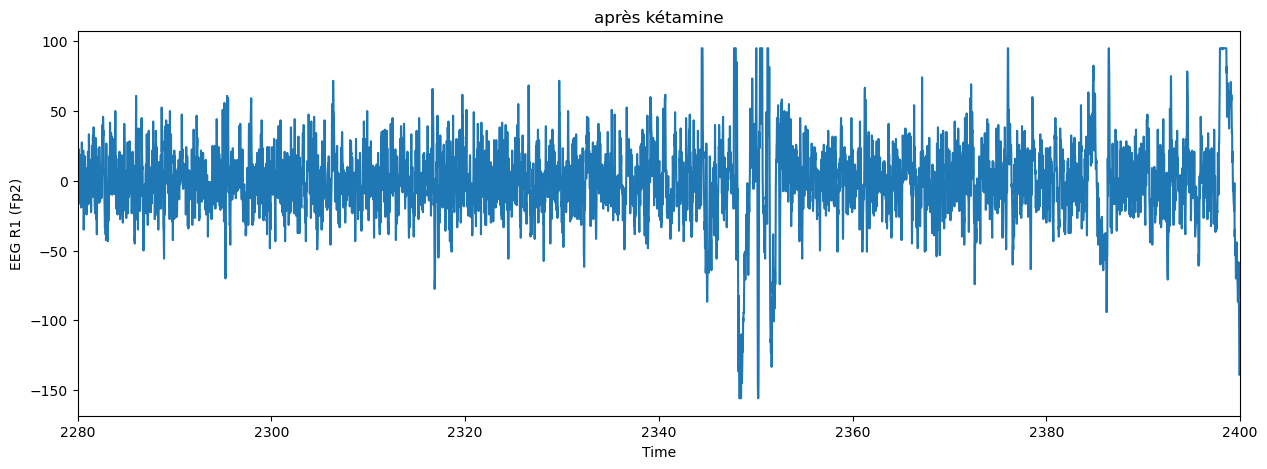

In [85]:
# Create a subplot
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the "EEG R1 (Fp2)" signal
ax.plot(df['Time'], df['EEG R1(Fp2)'])
ax.set_ylabel('EEG R1 (Fp2)')

# Add x and y axis labels
ax.set_xlabel('Time')
ax.set_xlim([2280, 2400])
ax.set_title("après kétamine")

# SEF95

Text(0.5, 1.0, 'SEF95 après kétamine')

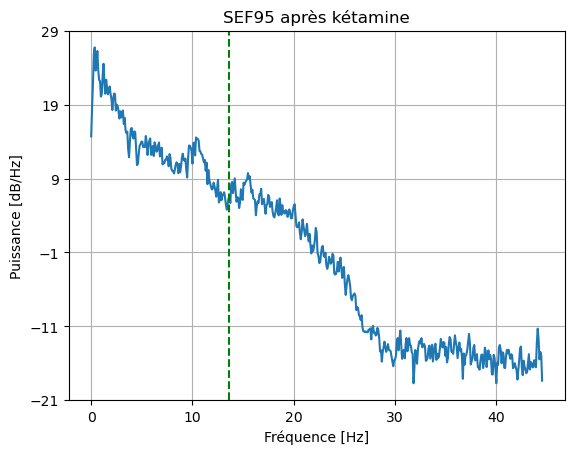

In [86]:
# Obtenir les données du signal et la fréquence d'échantillonnage
x = df['EEG R1(Fp2)'][int(2280*89.08):int(2400*89.08)]
Fs = 89.08 

# Calculer la transformée de Fourier du signal
X = np.fft.fft(x)

# Calculer la plage de fréquence
N = len(x)
f = np.linspace(0, Fs/2, N//2 + 1)

# Afficher la densité spectrale de puissance (PSD)
fig, ax = plt.subplots()
psd, freqs = ax.psd(x, NFFT=1024, Fs=Fs, window=np.hanning(1024), detrend='linear', noverlap=512, scale_by_freq=True)

# Calculer la SEF95
total_power = np.sum(psd)
cumulative_power = np.cumsum(psd)
sef95_idx = np.where(cumulative_power >= 0.95 * total_power)[0][0]
sef95_freq = freqs[sef95_idx]

# Afficher la SEF95
ax.axvline(sef95_freq, color='green', linestyle='--')


# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel('Puissance [dB/Hz]')
ax.set_title('SEF95 après kétamine')

In [87]:
print(f"SEF95 = {sef95_freq:.2f} Hz")

SEF95 = 13.57 Hz


# Delta

Text(0.5, 1.0, 'Onde delta après kétamine')

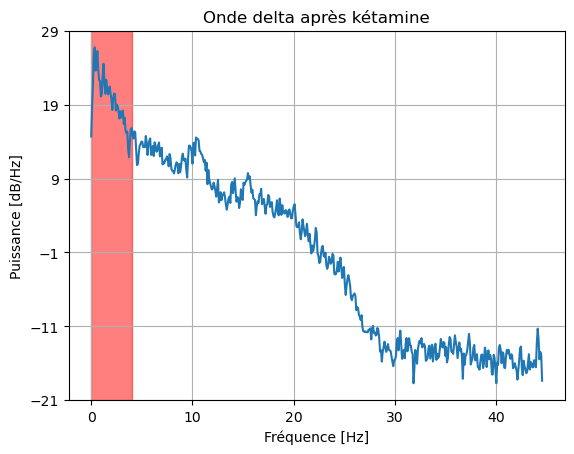

In [88]:
# Obtenir les données du signal et la fréquence d'échantillonnage
x = df['EEG R1(Fp2)'][int(2280*89.08):int(2400*89.08)]
Fs = 89.08 

# Calculer la transformée de Fourier du signal
X = np.fft.fft(x)

# Calculer la plage de fréquence
N = len(x)
f = np.linspace(0, Fs/2, N//2 + 1)

# Afficher la densité spectrale de puissance (PSD)
fig, ax = plt.subplots()
psd, freqs = ax.psd(x, NFFT=1024, Fs=Fs, window=np.hanning(1024), detrend='linear', noverlap=512, scale_by_freq=True)

# Identifier la bande alpha (8-13 Hz)
delta_start = 0.0
delta_end = 4.0
idx_delta = np.where((freqs >= delta_start) & (freqs <= delta_end))[0]

# Calculer la puissance alpha moyenne
delta_power = np.mean(psd[idx_delta])

# Afficher la bande alpha
ax.axvspan(delta_start, delta_end, alpha = 0.5, color='red')

# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel('Puissance [dB/Hz]')
ax.set_title('Onde delta après kétamine')

In [89]:
print("Puissance delta moyenne : {:.2f} dB/Hz".format(delta_power))

Puissance delta moyenne : 124.66 dB/Hz


# Thêta

Text(0.5, 1.0, 'Onde theta apres ketamine')

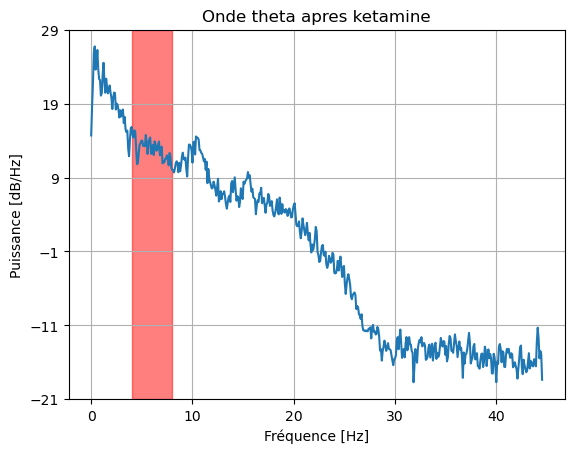

In [90]:
# Obtenir les données du signal et la fréquence d'échantillonnage
x = df['EEG R1(Fp2)'][int(2280*89.08):int(2400*89.08)]
Fs = 89.08 

# Calculer la transformée de Fourier du signal
X = np.fft.fft(x)

# Calculer la plage de fréquence
N = len(x)
f = np.linspace(0, Fs/2, N//2 + 1)

# Afficher la densité spectrale de puissance (PSD)
fig, ax = plt.subplots()
psd, freqs = ax.psd(x, NFFT=1024, Fs=Fs, window=np.hanning(1024), detrend='linear', noverlap=512, scale_by_freq=True)

# Identifier la bande alpha (8-13 Hz)
theta_start = 4.0
theta_end = 8.0
idx_theta = np.where((freqs >= theta_start) & (freqs <= theta_end))[0]

# Calculer la puissance alpha moyenne
theta_power = np.mean(psd[idx_theta])

# Afficher la bande alpha
ax.axvspan(theta_start, theta_end, alpha = 0.5, color='red')

# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel('Puissance [dB/Hz]')
ax.set_title('Onde theta apres ketamine')

In [91]:
print("Puissance theta moyenne : {:.2f} dB/Hz".format(theta_power))

Puissance theta moyenne : 20.45 dB/Hz


# Alpha

Text(0.5, 1.0, 'Onde alpha après kétamine')

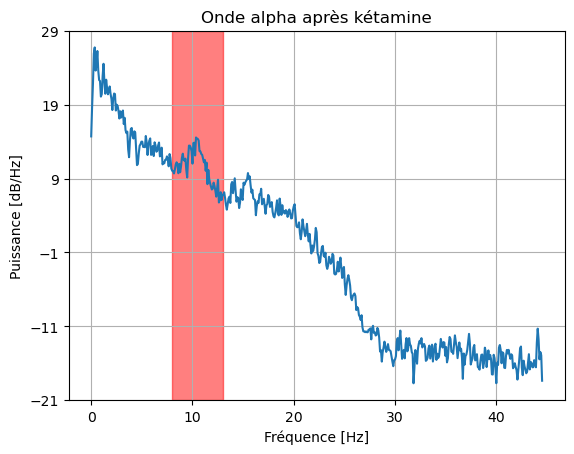

In [92]:
# Obtenir les données du signal et la fréquence d'échantillonnage
x = df['EEG R1(Fp2)'][int(2280*89.08):int(2400*89.08)]
Fs = 89.08 

# Calculer la transformée de Fourier du signal
X = np.fft.fft(x)

# Calculer la plage de fréquence
N = len(x)
f = np.linspace(0, Fs/2, N//2 + 1)

# Afficher la densité spectrale de puissance (PSD)
fig, ax = plt.subplots()
psd, freqs = ax.psd(x, NFFT=1024, Fs=Fs, window=np.hanning(1024), detrend='linear', noverlap=512, scale_by_freq=True)

# Identifier la bande alpha (8-13 Hz)
alpha_start = 8.0
alpha_end = 13.0
idx_alpha = np.where((freqs >= alpha_start) & (freqs <= alpha_end))[0]

# Calculer la puissance alpha moyenne
alpha_power = np.mean(psd[idx_alpha])

# Afficher la bande alpha
ax.axvspan(alpha_start, alpha_end, alpha=0.5, color='red')

# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel('Puissance [dB/Hz]')
ax.set_title('Onde alpha après kétamine')

In [93]:
print("Puissance alpha moyenne : {:.2f} dB/Hz".format(alpha_power))

Puissance alpha moyenne : 12.84 dB/Hz


# Béta

Text(0.5, 1.0, 'Onde beta après kétamine')

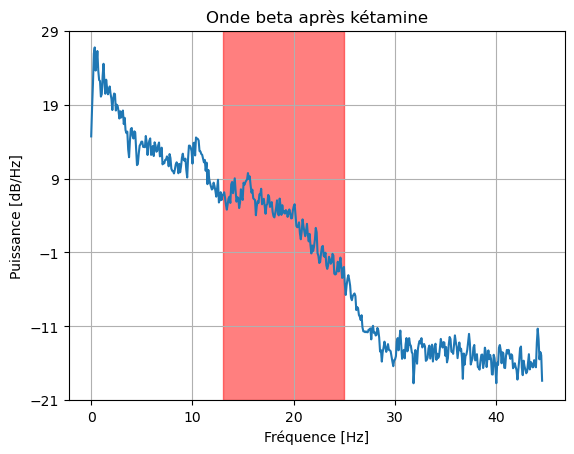

In [94]:
# Obtenir les données du signal et la fréquence d'échantillonnage
x = df['EEG R1(Fp2)'][int(2280*89.08):int(2400*89.08)]
Fs = 89.08 

# Calculer la transformée de Fourier du signal
X = np.fft.fft(x)

# Calculer la plage de fréquence
N = len(x)
f = np.linspace(0, Fs/2, N//2 + 1)

# Afficher la densité spectrale de puissance (PSD)
fig, ax = plt.subplots()
psd, freqs = ax.psd(x, NFFT=1024, Fs=Fs, window=np.hanning(1024), detrend='linear', noverlap=512, scale_by_freq=True)

# Identifier la bande alpha (8-13 Hz)
beta_start = 13.0
beta_end = 25.0
idx_beta = np.where((freqs >= beta_start) & (freqs <= beta_end))[0]

# Calculer la puissance alpha moyenne
beta_power = np.mean(psd[idx_beta])

# Afficher la bande alpha
ax.axvspan(beta_start, beta_end, alpha=0.5, color='red')

# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel('Puissance [dB/Hz]')
ax.set_title('Onde beta après kétamine')

In [95]:
print("Puissance beta moyenne : {:.2f} dB/Hz".format(beta_power))

Puissance beta moyenne : 2.94 dB/Hz


# Gamma

Text(0.5, 1.0, 'Onde gamma après kétamine')

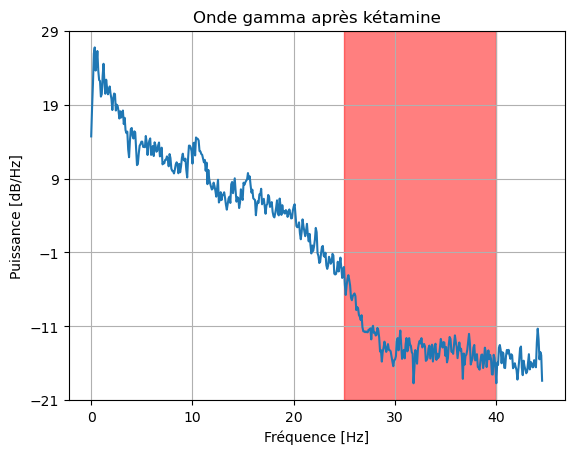

In [96]:
# Obtenir les données du signal et la fréquence d'échantillonnage
x = df['EEG R1(Fp2)'][int(2280*89.08):int(2400*89.08)]
Fs = 89.08 

# Calculer la transformée de Fourier du signal
X = np.fft.fft(x)

# Calculer la plage de fréquence
N = len(x)
f = np.linspace(0, Fs/2, N//2 + 1)

# Afficher la densité spectrale de puissance (PSD)
fig, ax = plt.subplots()
psd, freqs = ax.psd(x, NFFT=1024, Fs=Fs, window=np.hanning(1024), detrend='linear', noverlap=512, scale_by_freq=True)

# Identifier la bande alpha (8-13 Hz)
gamma_start = 25.0
gamma_end = 40.0
idx_gamma = np.where((freqs >= gamma_start) & (freqs <= gamma_end))[0]

# Calculer la puissance alpha moyenne
gamma_power = np.mean(psd[idx_gamma])

# Afficher la bande alpha
ax.axvspan(gamma_start, gamma_end, alpha=0.5, color='red')

# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel('Puissance [dB/Hz]')
ax.set_title('Onde gamma après kétamine')

In [98]:
print("Puissance gamma moyenne : {:.2f} dB/Hz".format(gamma_power))

Puissance gamma moyenne : 0.06 dB/Hz


In [865]:
moyennes_puissances = pd.read_csv(r"C:\Users\nico_\Desktop\INSERM\Projet ICEO\moyennes_puissances_csv.csv", sep=';', encoding='ISO-8859-1')

In [866]:
moyennes_puissances

Réponse   P Delta av ket  P Delta ap ket  P Thêta av ket  P Thêta ap ket  \
0  positif           59.32           45.41           10.23            8.95   
1  negatif          180.94          190.33            7.83            8.00   

   P Alpha av ket  P Alpha ap ket  P Bêta av ket  P Bêta ap ket  \
0           10.54            8.17           1.37           3.28   
1            5.56            5.49           0.83           1.02   

   P Gamma av ket  P Gamma ap ket  
0            0.04            0.08  
1            0.03            0.03

In [867]:
avket = moyennes_puissances.loc[:,["Réponse ","P Delta av ket","P Thêta av ket","P Alpha av ket","P Bêta av ket","P Gamma av ket"]]

In [868]:
apket = moyennes_puissances.loc[:,["Réponse ","P Delta ap ket","P Thêta ap ket","P Alpha ap ket","P Bêta ap ket","P Gamma ap ket"]]

In [869]:
avket

Réponse   P Delta av ket  P Thêta av ket  P Alpha av ket  P Bêta av ket  \
0  positif           59.32           10.23           10.54           1.37   
1  negatif          180.94            7.83            5.56           0.83   

   P Gamma av ket  
0            0.04  
1            0.03

In [870]:
apket

Réponse   P Delta ap ket  P Thêta ap ket  P Alpha ap ket  P Bêta ap ket  \
0  positif           45.41            8.95            8.17           3.28   
1  negatif          190.33            8.00            5.49           1.02   

   P Gamma ap ket  
0            0.08  
1            0.03

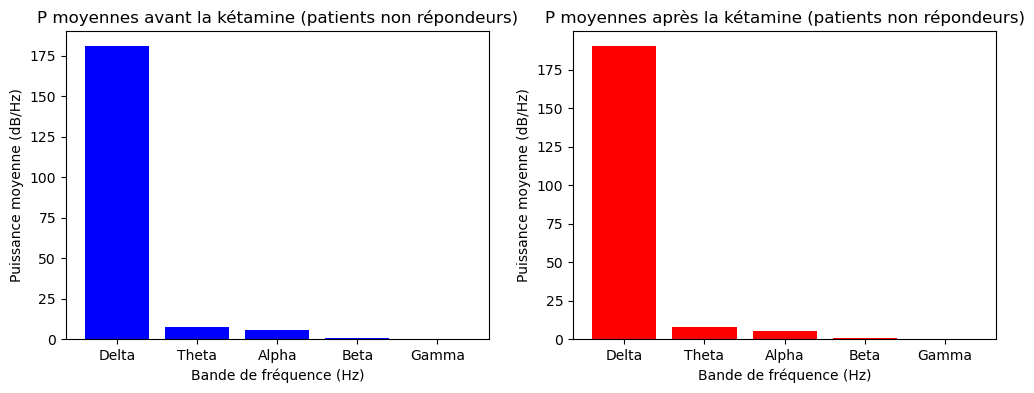

In [871]:
puissances_av = moyennes_puissances.loc[1, ['P Delta av ket', 'P Thêta av ket', 'P Alpha av ket', 'P Bêta av ket', 'P Gamma av ket']]
puissances_ap = moyennes_puissances.loc[1, ['P Delta ap ket', 'P Thêta ap ket', 'P Alpha ap ket', 'P Bêta ap ket', 'P Gamma ap ket']]

# Plages de fréquences pour chaque bande
bandes_frequences = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(bandes_frequences, puissances_av, color='blue')
ax1.set_xlabel('Bande de fréquence (Hz)')
ax1.set_ylabel('Puissance moyenne (dB/Hz)')
ax1.set_title('P moyennes avant la kétamine (patients non répondeurs)')

ax2.bar(bandes_frequences, puissances_ap, color='red')
ax2.set_xlabel('Bande de fréquence (Hz)')
ax2.set_ylabel('Puissance moyenne (dB/Hz)')
ax2.set_title('P moyennes après la kétamine (patients non répondeurs)')

plt.show()


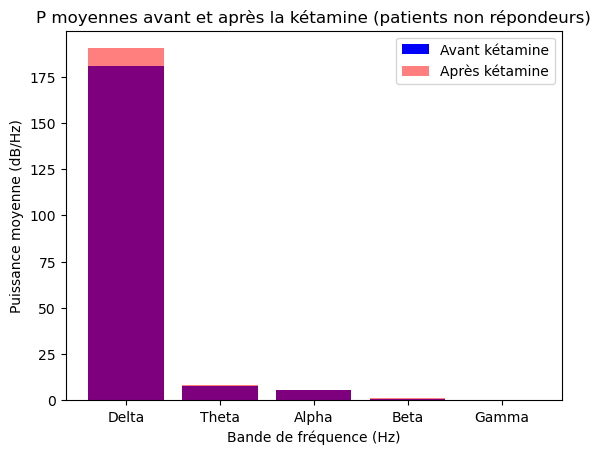

In [872]:
fig, ax = plt.subplots()

ax.bar(bandes_frequences, puissances_av, color='blue', label='Avant kétamine')

ax.bar(bandes_frequences, puissances_ap, color='red', label='Après kétamine', alpha=0.5)

ax.set_xlabel('Bande de fréquence (Hz)')
ax.set_ylabel('Puissance moyenne (dB/Hz)')
ax.set_title('P moyennes avant et après la kétamine (patients non répondeurs)')

ax.legend()

plt.show()

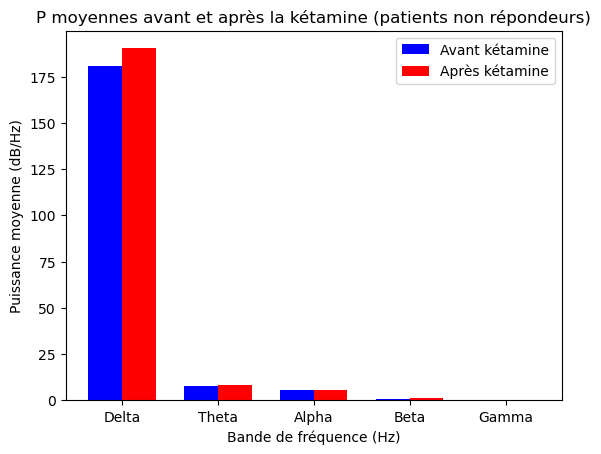

In [873]:
bandes_frequences = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

fig, ax = plt.subplots()

# Largeur des barres
width = 0.35

# Position des barres pour chaque groupe
pos_av = np.arange(len(bandes_frequences))
pos_ap = pos_av + width

ax.bar(pos_av, puissances_av, width, color='blue', label='Avant kétamine')

ax.bar(pos_ap, puissances_ap, width, color='red', label='Après kétamine')

ax.set_xlabel('Bande de fréquence (Hz)')
ax.set_ylabel('Puissance moyenne (dB/Hz)')
ax.set_title('P moyennes avant et après la kétamine (patients non répondeurs)')

ax.set_xticks((pos_av + pos_ap) / 2)
ax.set_xticklabels(bandes_frequences)

ax.legend()

plt.show()


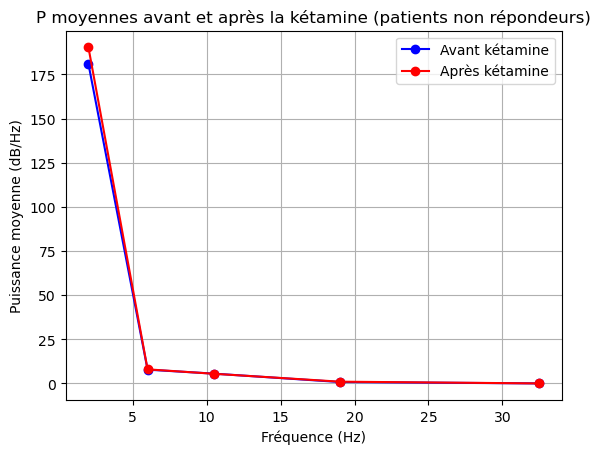

In [874]:
bandes_frequences = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

frequences_centrales = [2, 6, 10.5, 19, 32.5]

fig, ax = plt.subplots()

ax.plot(frequences_centrales, puissances_av, color='blue', label='Avant kétamine', marker='o')

ax.plot(frequences_centrales, puissances_ap, color='red', label='Après kétamine', marker='o')

ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Puissance moyenne (dB/Hz)')
ax.set_title('P moyennes avant et après la kétamine (patients non répondeurs)')

ax.legend()

plt.grid(True)

plt.show()


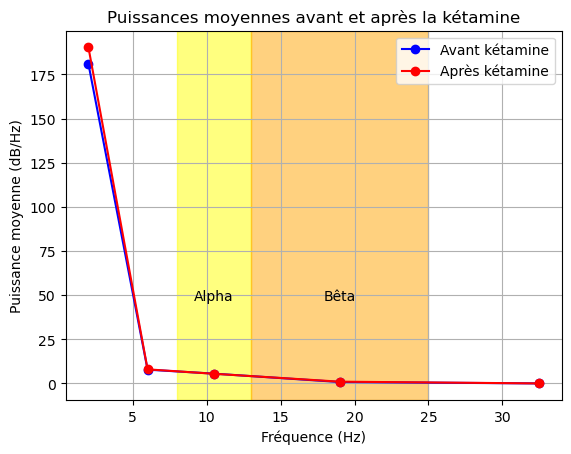

In [875]:
# Plages de fréquences pour chaque bande
bandes_frequences = ['Delta', 'Theta', 'Alpha', 'Bêta', 'Gamma']

# Fréquences centrales des bandes de fréquence
frequences_centrales = [2, 6, 10.5, 19, 32.5]

# Créer la figure et les axes
fig, ax = plt.subplots()

# Tracer les courbes des puissances moyennes avant et après la kétamine
ax.plot(frequences_centrales, puissances_av, color='blue', label='Avant kétamine', marker='o')
ax.plot(frequences_centrales, puissances_ap, color='red', label='Après kétamine', marker='o')

# Identifier la bande alpha (8-13 Hz) avec une couleur jaune
alpha_start = 8.0
alpha_end = 13.0
ax.axvspan(alpha_start, alpha_end, alpha=0.5, color='yellow')

# Identifier la bande bêta (13-25 Hz) avec une couleur orange
beta_start = 13.0
beta_end = 25.0
ax.axvspan(beta_start, beta_end, alpha=0.5, color='orange')

# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Puissance moyenne (dB/Hz)')
ax.set_title('Puissances moyennes avant et après la kétamine')

# Position des étiquettes des bandes en haut et au milieu de chaque bande
label_y = max(max(puissances_av[2], puissances_ap[2]), max(puissances_av[3], puissances_ap[3])) + 40

# Ajouter les étiquettes des bandes en haut et au milieu de chaque bande
for i, freq_centrale in enumerate(frequences_centrales[2:4], start=2):
    ax.text(freq_centrale, label_y, bandes_frequences[i], ha='center', va='bottom', color='black', fontsize=10)

# Afficher la légende et la grille
ax.legend()
ax.grid(True)

# Afficher le graphique
plt.show()


In [876]:
puissances_ap

P Delta ap ket    190.33
P Thêta ap ket       8.0
P Alpha ap ket      5.49
P Bêta ap ket       1.02
P Gamma ap ket      0.03
Name: 1, dtype: object

# Fonction log10

Répondeur

In [877]:
puissances_av = moyennes_puissances.loc[0, ['P Delta av ket', 'P Thêta av ket', 'P Alpha av ket', 'P Bêta av ket', 'P Gamma av ket']]
puissances_ap = moyennes_puissances.loc[0, ['P Delta ap ket', 'P Thêta ap ket', 'P Alpha ap ket', 'P Bêta ap ket', 'P Gamma ap ket']]

puissances_av_log10 = puissances_av.apply(lambda x: np.log10(x) if np.issubdtype(x.dtype, np.number) else x)
puissances_ap_log10 = puissances_ap.apply(lambda x: np.log10(x) if np.issubdtype(x.dtype, np.number) else x)

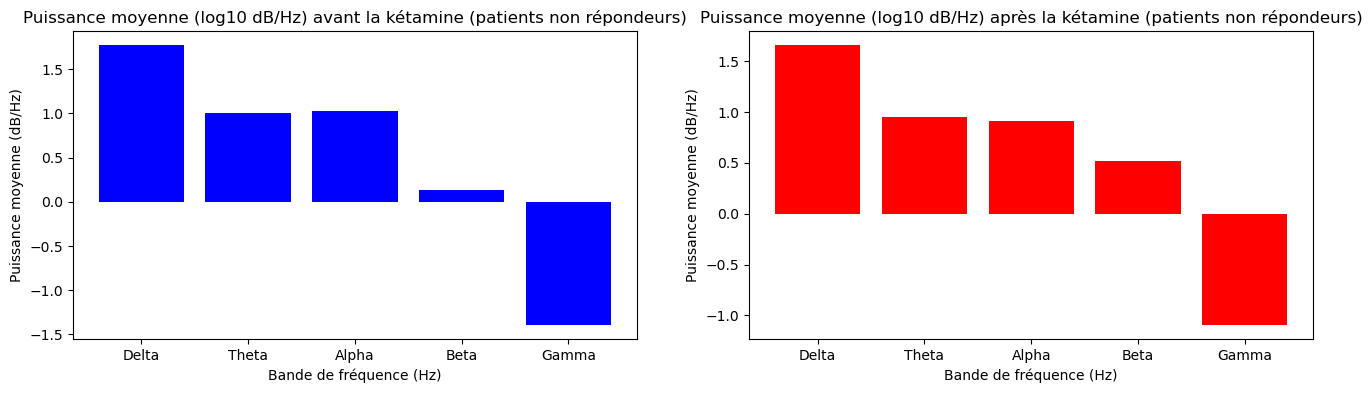

In [878]:
# Plages de fréquences pour chaque bande
bandes_frequences = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.bar(bandes_frequences, puissances_av_log10, color='blue')
ax1.set_xlabel('Bande de fréquence (Hz)')
ax1.set_ylabel('Puissance moyenne (dB/Hz)')
ax1.set_title('Puissance moyenne (log10 dB/Hz) avant la kétamine (patients non répondeurs)')

ax2.bar(bandes_frequences, puissances_ap_log10, color='red')
ax2.set_xlabel('Bande de fréquence (Hz)')
ax2.set_ylabel('Puissance moyenne (dB/Hz)')
ax2.set_title('Puissance moyenne (log10 dB/Hz) après la kétamine (patients non répondeurs)')

plt.show()

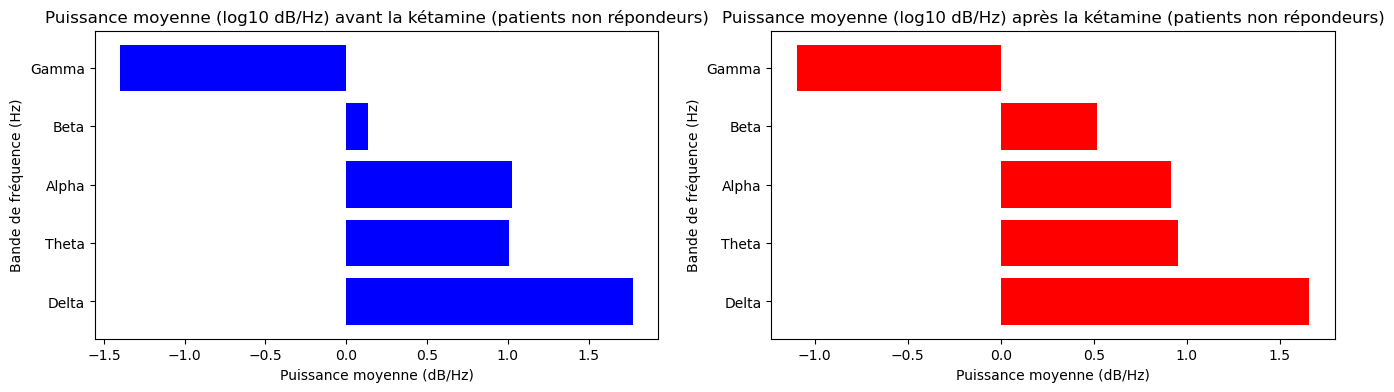

In [879]:
# Plages de fréquences pour chaque bande
bandes_frequences = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.barh(bandes_frequences, puissances_av_log10, color='blue')
ax1.set_ylabel('Bande de fréquence (Hz)')
ax1.set_xlabel('Puissance moyenne (dB/Hz)')
ax1.set_title('Puissance moyenne (log10 dB/Hz) avant la kétamine (patients non répondeurs)')

ax2.barh(bandes_frequences, puissances_ap_log10, color='red')
ax2.set_ylabel('Bande de fréquence (Hz)')
ax2.set_xlabel('Puissance moyenne (dB/Hz)')
ax2.set_title('Puissance moyenne (log10 dB/Hz) après la kétamine (patients non répondeurs)')

plt.show()

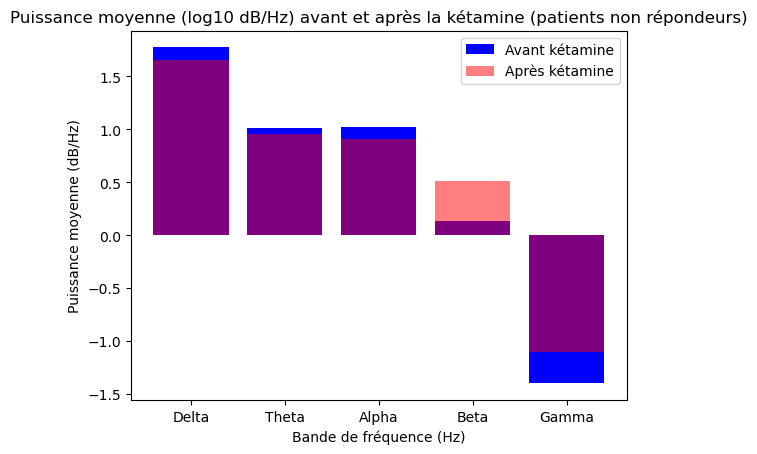

In [880]:
fig, ax = plt.subplots()

ax.bar(bandes_frequences, puissances_av_log10, color='blue', label='Avant kétamine')

ax.bar(bandes_frequences, puissances_ap_log10, color='red', label='Après kétamine', alpha=0.5)

ax.set_xlabel('Bande de fréquence (Hz)')
ax.set_ylabel('Puissance moyenne (dB/Hz)')
ax.set_title('Puissance moyenne (log10 dB/Hz) avant et après la kétamine (patients non répondeurs)')

ax.legend()

plt.show()

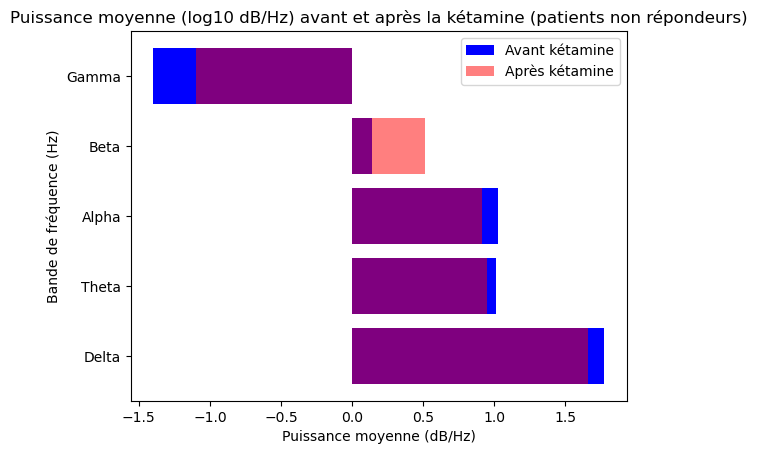

In [881]:
fig, ax = plt.subplots()

ax.barh(bandes_frequences, puissances_av_log10, color='blue', label='Avant kétamine')

ax.barh(bandes_frequences, puissances_ap_log10, color='red', label='Après kétamine', alpha=0.5)

ax.set_ylabel('Bande de fréquence (Hz)')
ax.set_xlabel('Puissance moyenne (dB/Hz)')
ax.set_title('Puissance moyenne (log10 dB/Hz) avant et après la kétamine (patients non répondeurs)')

ax.legend()

plt.show()

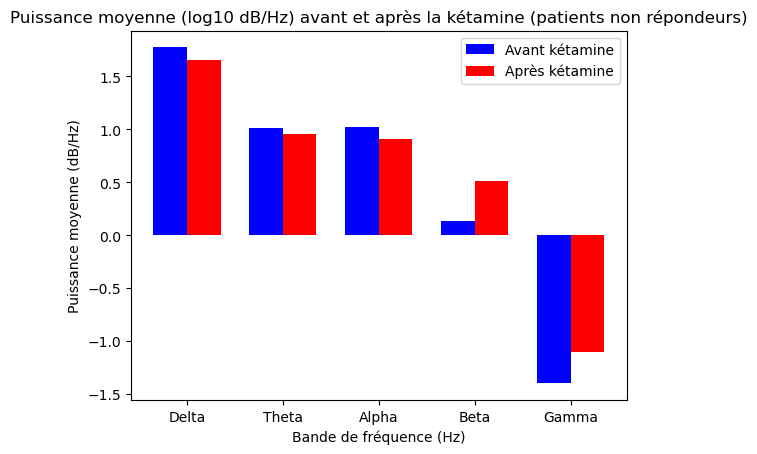

In [882]:
bandes_frequences = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

fig, ax = plt.subplots()

# Largeur des barres
width = 0.35

# Position des barres pour chaque groupe
pos_av = np.arange(len(bandes_frequences))
pos_ap = pos_av + width

ax.bar(pos_av, puissances_av_log10, width, color='blue', label='Avant kétamine')

ax.bar(pos_ap, puissances_ap_log10, width, color='red', label='Après kétamine')

ax.set_xlabel('Bande de fréquence (Hz)')
ax.set_ylabel('Puissance moyenne (dB/Hz)')
ax.set_title('Puissance moyenne (log10 dB/Hz) avant et après la kétamine (patients non répondeurs)')

ax.set_xticks((pos_av + pos_ap) / 2)
ax.set_xticklabels(bandes_frequences)

ax.legend()

plt.show()


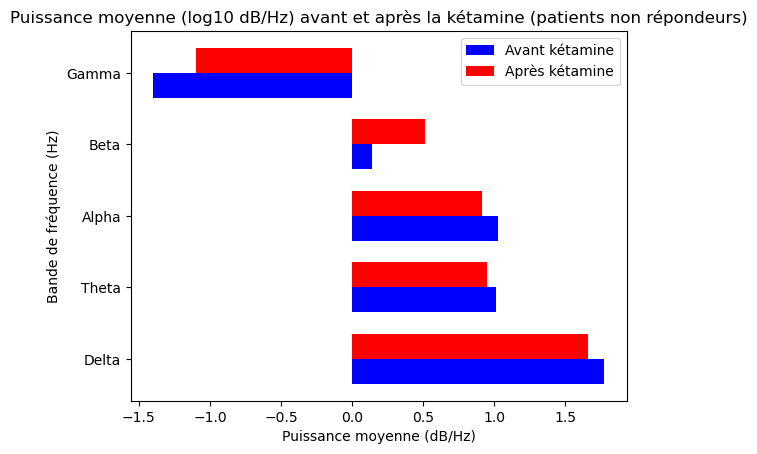

In [883]:
bandes_frequences = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Assuming you have defined the variables puissances_av_log10 and puissances_ap_log10

fig, ax = plt.subplots()

# Width of the bars
width = 0.35

# Position of the bars for each group
pos_av = np.arange(len(bandes_frequences))
pos_ap = pos_av + width

ax.barh(pos_av, puissances_av_log10, width, color='blue', label='Avant kétamine')
ax.barh(pos_ap, puissances_ap_log10, width, color='red', label='Après kétamine')

ax.set_ylabel('Bande de fréquence (Hz)')
ax.set_xlabel('Puissance moyenne (dB/Hz)')
ax.set_title('Puissance moyenne (log10 dB/Hz) avant et après la kétamine (patients non répondeurs)')

ax.set_yticks((pos_av + pos_ap) / 2)
ax.set_yticklabels(bandes_frequences)

ax.legend()

plt.show()


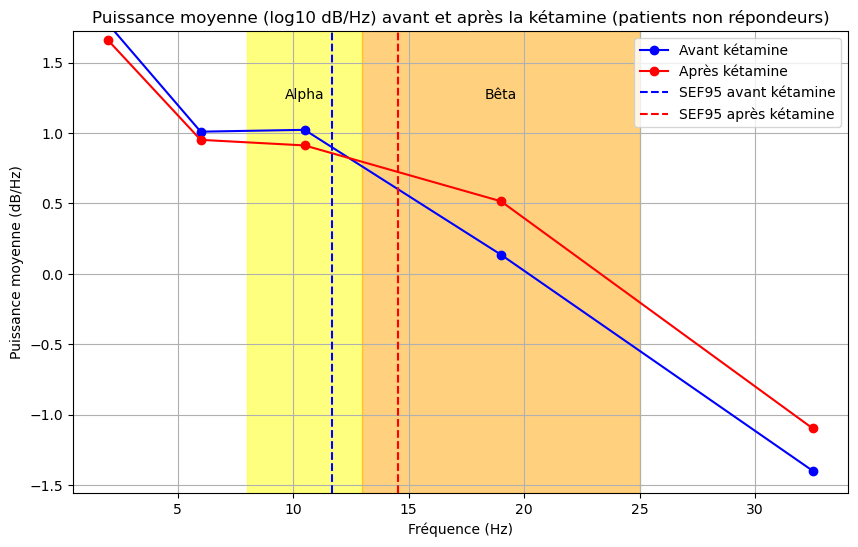

In [884]:
# Plages de fréquences pour chaque bande
bandes_frequences = ['Delta', 'Theta', 'Alpha', 'Bêta', 'Gamma']

# Fréquences centrales des bandes de fréquence
frequences_centrales = [2, 6, 10.5, 19, 32.5]

# Créer la figure et les axes
fig, ax = plt.subplots(figsize = (10,6))

# Tracer les courbes des puissances moyennes avant et après la kétamine
ax.plot(frequences_centrales, puissances_av_log10, color='blue', label='Avant kétamine', marker='o')
ax.plot(frequences_centrales, puissances_ap_log10, color='red', label='Après kétamine', marker='o')

# Identifier la bande alpha (8-13 Hz) avec une couleur jaune
alpha_start = 8.0
alpha_end = 13.0
ax.axvspan(alpha_start, alpha_end, alpha=0.5, color='yellow')

# Identifier la bande bêta (13-25 Hz) avec une couleur orange
beta_start = 13.0
beta_end = 25.0
ax.axvspan(beta_start, beta_end, alpha=0.5, color='orange')

# Moyennes SEF95:

sef95_freq_av = data_puissance["SEF95 av ket"].mean()
sef95_freq_ap = data_puissance["SEF95 ap ket"].mean()

# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Puissance moyenne (dB/Hz)')
ax.set_title('Puissance moyenne (log10 dB/Hz) avant et après la kétamine (patients non répondeurs)')

# Position des étiquettes des bandes en haut et au milieu de chaque bande
label_y = max(max(puissances_av_log10[2], puissances_ap_log10[2]), max(puissances_av_log10[3], puissances_ap_log10[3])) + 0.2

# Ajouter les étiquettes des bandes en haut et au milieu de chaque bande
for i, freq_centrale in enumerate(frequences_centrales[2:4], start=2):
    ax.text(freq_centrale, label_y, bandes_frequences[i], ha='center', va='bottom', color='black', fontsize=10)

# Ajuster la limite supérieure de l'axe y pour laisser de la place aux noms des bandes
ax.set_ylim(ax.get_ylim()[0], label_y + 0.5)

# Affichage SEF 95

ax.axvline(sef95_freq_av, color='blue', linestyle='--', label='SEF95 avant kétamine')
ax.axvline(sef95_freq_ap, color='red', linestyle='--', label='SEF95 après kétamine')

# Afficher la légende et la grille
ax.legend()
ax.grid(True)

# Afficher le graphique
plt.show()

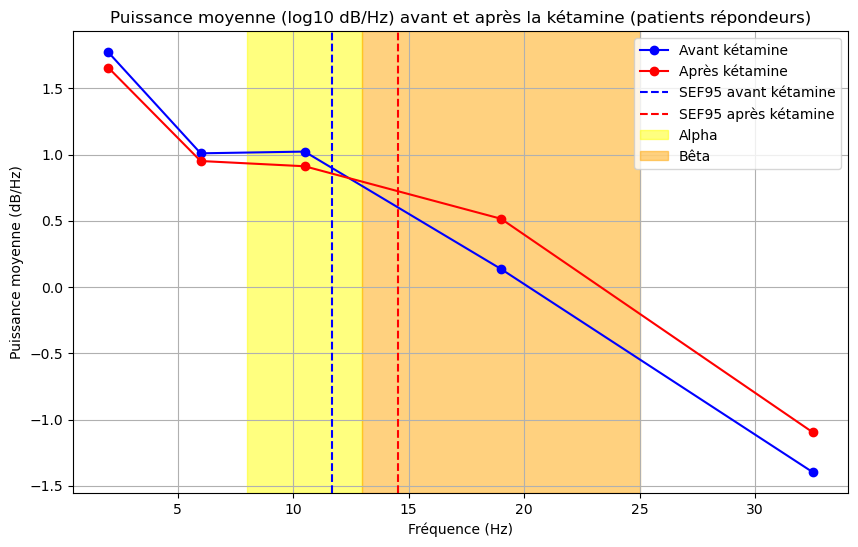

In [885]:
# Plages de fréquences pour chaque bande
bandes_frequences = ['Delta', 'Theta', 'Alpha', 'Bêta', 'Gamma']

# Fréquences centrales des bandes de fréquence
frequences_centrales = [2, 6, 10.5, 19, 32.5]

# Créer la figure et les axes
fig, ax = plt.subplots(figsize = (10,6))

# Tracer les courbes des puissances moyennes avant et après la kétamine
ax.plot(frequences_centrales, puissances_av_log10, color='blue', label='Avant kétamine', marker='o')
ax.plot(frequences_centrales, puissances_ap_log10, color='red', label='Après kétamine', marker='o')

# Moyennes SEF95:

sef95_freq_av = data_puissance["SEF95 av ket"].mean()
sef95_freq_ap = data_puissance["SEF95 ap ket"].mean()

# Affichage SEF 95

ax.axvline(sef95_freq_av, color='blue', linestyle='--', label='SEF95 avant kétamine')
ax.axvline(sef95_freq_ap, color='red', linestyle='--', label='SEF95 après kétamine')

# Identifier la bande alpha (8-13 Hz) avec une couleur jaune
alpha_start = 8.0
alpha_end = 13.0
ax.axvspan(alpha_start, alpha_end, alpha=0.5, color='yellow', label='Alpha')

# Identifier la bande bêta (13-25 Hz) avec une couleur orange
beta_start = 13.0
beta_end = 25.0
ax.axvspan(beta_start, beta_end, alpha=0.5, color='orange', label='Bêta')


# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Puissance moyenne (dB/Hz)')
ax.set_title('Puissance moyenne (log10 dB/Hz) avant et après la kétamine (patients répondeurs)')


# Afficher la légende et la grille
ax.legend()
ax.grid(True)

plt.show()

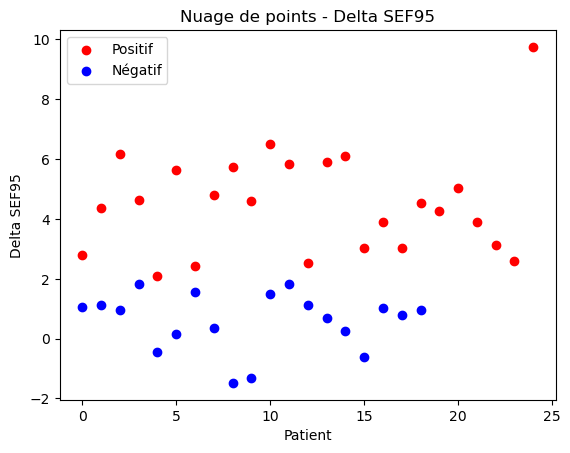

In [886]:
import matplotlib.pyplot as plt

# Coordonnées x et y pour les données positives
x_pos = range(len(data_puissance_pos['Delta SEF95']))
y_pos = data_puissance_pos['Delta SEF95']

# Coordonnées x et y pour les données négatives
x_neg = range(len(data_puissance_neg['Delta SEF95']))
y_neg = data_puissance_neg['Delta SEF95']

# Création du nuage de points
plt.scatter(x_pos, y_pos, color='red', label='Positif')
plt.scatter(x_neg, y_neg, color='blue', label='Négatif')

# Ajout des légendes et titres
plt.xlabel('Patient')
plt.ylabel('Delta SEF95')
plt.title('Nuage de points - Delta SEF95')
plt.legend()

# Affichage du nuage de points
plt.show()


# PCA

In [887]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [888]:
data_puissance_2 = data_puissance.drop(["Effet","Patient"], axis=1)

In [889]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(data_puissance_2)

In [890]:
pca = PCA(n_components=2) 

X_pca = pca.fit_transform(X_scaled)

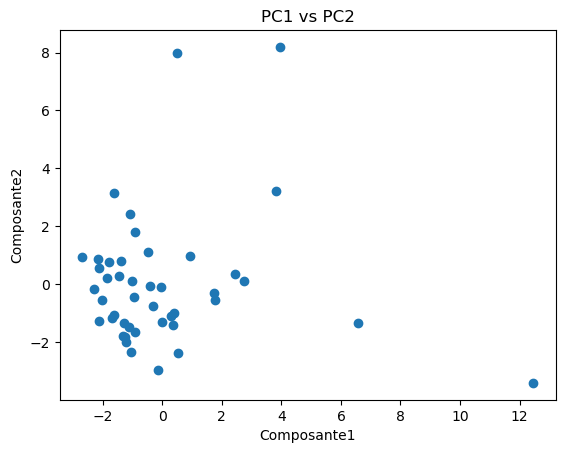

In [891]:
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel('Composante1')
plt.ylabel('Composante2')
plt.title('PC1 vs PC2')
plt.show()

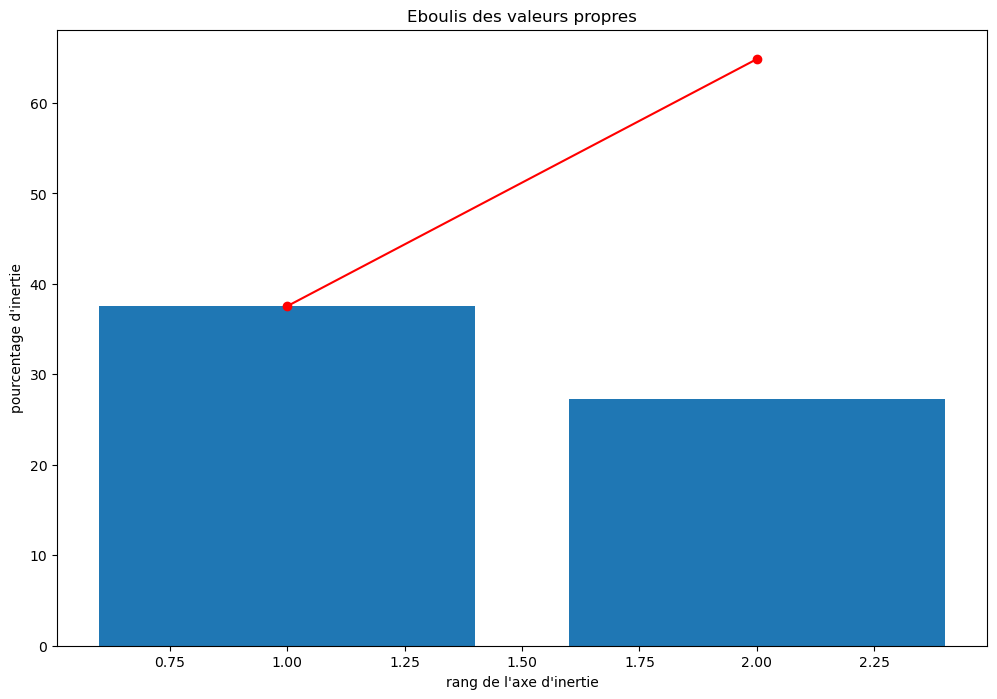

In [892]:
#Variances expliquées
varexpl = pca.explained_variance_ratio_*100

#Projection de l'éboulis des valeurs propres
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)
plt.plot(np.arange(len(varexpl))+1, varexpl.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [893]:
X_pcadf=pd.DataFrame(data=X_pca,columns=['pca1','pca2'])

In [894]:
finaldf=pd.concat([X_pcadf, data_puissance["Patient"]], axis=1)

In [895]:
import plotly.express as px

fig = px.scatter(finaldf, x='pca1', y='pca2', color=data_puissance["Patient"])
fig.show()

In [896]:
from sklearn.cluster import KMeans

In [897]:
# pip install --user scikit-learn

In [898]:
cluster_model = KMeans(n_clusters= 2)
cluster_model.fit(X_pca)
clusters = cluster_model.predict(X_pca)

C:\Users\nico_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\nico_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



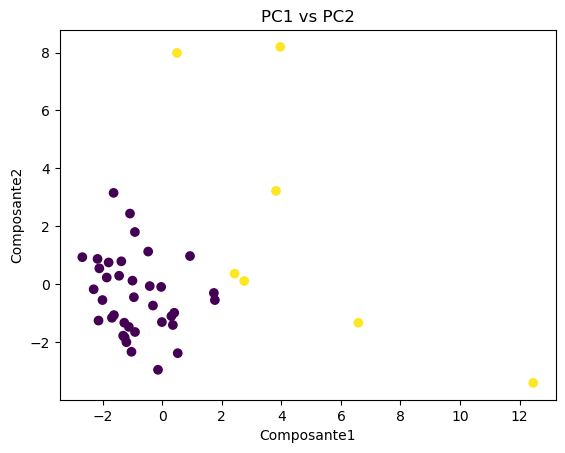

In [899]:
plt.scatter(X_pca[:,0], X_pca[:,1], c = clusters)
plt.xlabel('Composante1')
plt.ylabel('Composante2')
plt.title('PC1 vs PC2')
plt.show()

In [900]:
fig = px.scatter(finaldf, x='pca1', y='pca2', color=clusters, hover_data=[data_puissance["Patient"]])
fig.show()


In [901]:
data_puissance['Cluster'] = clusters

# Recherche du nombre de cluster

In [902]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [903]:
from yellowbrick.cluster import KElbowVisualizer

C:\Users\nico_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\nico_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\nico_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\nico_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\n

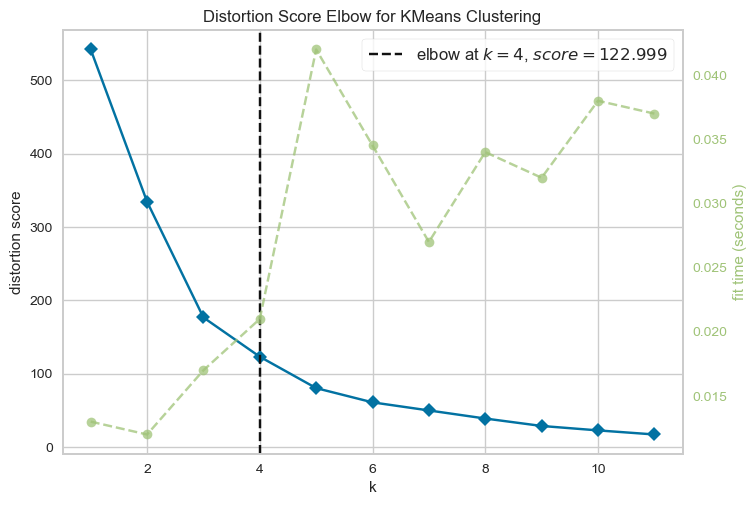

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [904]:
kmeans2 = KMeans()
visualiser = KElbowVisualizer(kmeans2, k= (1,12))
visualiser.fit(X_pca)
visualiser.show()

In [905]:
cluster_model = KMeans(n_clusters= 4)
cluster_model.fit(X_pca)
clusters4 = cluster_model.predict(X_pca)

C:\Users\nico_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\nico_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [906]:
fig = px.scatter(finaldf, x='pca1', y='pca2', color=clusters4, hover_data=[data_puissance["Patient"]])
fig.show()

In [907]:
data_puissance['Cluster4'] = clusters4

In [908]:
data_puissance.head()

Patient    Effet  SEF95 av ket  SEF95 ap ket  P Delta av ket  \
0  DELAHAYE Matthis  positif         10.79         13.57          132.72   
1   GRENAND Thierry  positif         16.96         18.01            5.60   
2     CERTILI Ender  negatif         12.18         16.53           55.67   
3  JOSEPHRAS Edward  negatif         14.09         15.22           11.35   
4   TRAORE Salimata  negatif         11.92         12.87           15.08   

   P Delta ap ket  P Thêta av ket  P Thêta ap ket  P Alpha av ket  \
0          124.66           10.91           20.45            8.53   
1           11.43            0.68            0.56            1.52   
2           41.93           48.94           18.44            8.94   
3           11.51            3.12            4.51            2.72   
4           14.66            2.52            3.18            1.47   

   P Alpha ap ket  ...  P Gamma ap ket  Delta SEF95  Delta Delta  Delta Thêta  \
0           12.84  ...            0.06         2.78        -8.06         9.54   
1            0.94  ...            0.01         1.05         5.83        -0.12   
2           14.86  ...            0.07         4.35       -13.74       -30.50   
3            1.99  ...            0.01         1.13         0.16         1.39   
4            0.99  ...            0.01         0.95        -0.42         0.66   

   Delta Alpha  Bêta activation  Delta Gamma  Reponse  Cluster  Cluster4  
0         4.31             1.22        -0.01        1        0         3  
1        -0.58             0.16         0.00        0        0         0  
2         5.92             1.57         0.02        1        1         3  
3        -0.73             0.10         0.00        0        0         0  
4        -0.48             0.04         0.00        0        0         0  

[5 rows x 23 columns]

In [909]:
table = pd.crosstab(data_puissance['Reponse'], data_puissance['Cluster'])
# Calcul du test du chi2 avec correction de Yates
chi2_yates, p_yates, dof_yates, expected_yates = chi2_contingency(table, correction=True)

# Calcul du test du chi2 avec méthode de Pearson
chi2_pearson, p_pearson, dof_pearson, expected_pearson = chi2_contingency(table)

# Affichage des résultats
# Affichage des résultats
print("Test du chi2 avec correction de Yates:")
print(f"chi2 = {chi2_yates}, p-value = {p_yates}, degrés de liberté = {dof_yates}")
print("Tableau des fréquences attendues:")
print(expected_yates.round())

print("\nTest du chi2 avec méthode de Pearson:")
print(f"chi2 = {chi2_pearson}, p-value = {p_pearson}, degrés de liberté = {dof_pearson}")
print("Tableau des fréquences attendues:")
print(expected_pearson.round())

Test du chi2 avec correction de Yates:
chi2 = 0.18919731761837044, p-value = 0.6635855243257953, degrés de liberté = 1
Tableau des fréquences attendues:
[[16.  3.]
 [21.  4.]]

Test du chi2 avec méthode de Pearson:
chi2 = 0.18919731761837044, p-value = 0.6635855243257953, degrés de liberté = 1
Tableau des fréquences attendues:
[[16.  3.]
 [21.  4.]]


# Kmeans SEF95

In [910]:
data_puissance_3 = data_puissance[["SEF95 av ket", "SEF95 ap ket"]]

In [911]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_puissance_3)

In [912]:
X = pd.DataFrame(data=X_scaled, columns=['SEF95 av ket','SEF95 ap ket'])

In [913]:
X.head()

SEF95 av ket  SEF95 ap ket
0     -0.282634     -0.208294
1      1.648637      0.757811
2      0.152450      0.435776
3      0.750299      0.150731
4      0.071067     -0.360608

In [914]:
cluster_model = KMeans(n_clusters= 2)
cluster_model.fit(X)
clustersSEF95 = cluster_model.predict(X)

C:\Users\nico_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\nico_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [915]:
X.head()

SEF95 av ket  SEF95 ap ket
0     -0.282634     -0.208294
1      1.648637      0.757811
2      0.152450      0.435776
3      0.750299      0.150731
4      0.071067     -0.360608

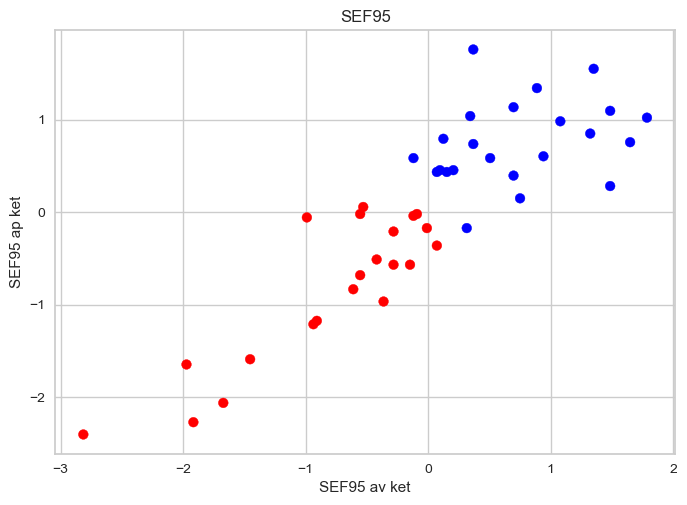

In [916]:
# Définir les couleurs pour les deux clusters
colors = np.array(['red', 'blue'])

# Tracer le nuage de points avec les couleurs personnalisées
plt.scatter(X['SEF95 av ket'], X['SEF95 ap ket'], c=colors[clustersSEF95])
plt.xlabel('SEF95 av ket')
plt.ylabel('SEF95 ap ket')
plt.title('SEF95')
plt.show()

In [917]:
finaldf=pd.concat([X, data_puissance["Patient"]], axis=1)

In [918]:
fig = px.scatter(finaldf, x='SEF95 av ket', y='SEF95 ap ket', color=clustersSEF95, hover_data=[data_puissance["Patient"]])
fig.show()

In [919]:
data_puissance["clusterSEF95"] = clustersSEF95

In [920]:
table = pd.crosstab(data_puissance['Reponse'], data_puissance['clusterSEF95'])
# Calcul du test du chi2 avec correction de Yates
chi2_yates, p_yates, dof_yates, expected_yates = chi2_contingency(table, correction=True)

# Calcul du test du chi2 avec méthode de Pearson
chi2_pearson, p_pearson, dof_pearson, expected_pearson = chi2_contingency(table)

# Affichage des résultats
# Affichage des résultats
print("Test du chi2 avec correction de Yates:")
print(f"chi2 = {chi2_yates}, p-value = {p_yates}, degrés de liberté = {dof_yates}")
print("Tableau des fréquences attendues:")
print(expected_yates.round())

print("\nTest du chi2 avec méthode de Pearson:")
print(f"chi2 = {chi2_pearson}, p-value = {p_pearson}, degrés de liberté = {dof_pearson}")
print("Tableau des fréquences attendues:")
print(expected_pearson.round())

Test du chi2 avec correction de Yates:
chi2 = 7.292579274272639, p-value = 0.006923999920975221, degrés de liberté = 1
Tableau des fréquences attendues:
[[ 9. 10.]
 [12. 13.]]

Test du chi2 avec méthode de Pearson:
chi2 = 7.292579274272639, p-value = 0.006923999920975221, degrés de liberté = 1
Tableau des fréquences attendues:
[[ 9. 10.]
 [12. 13.]]


# Réponse

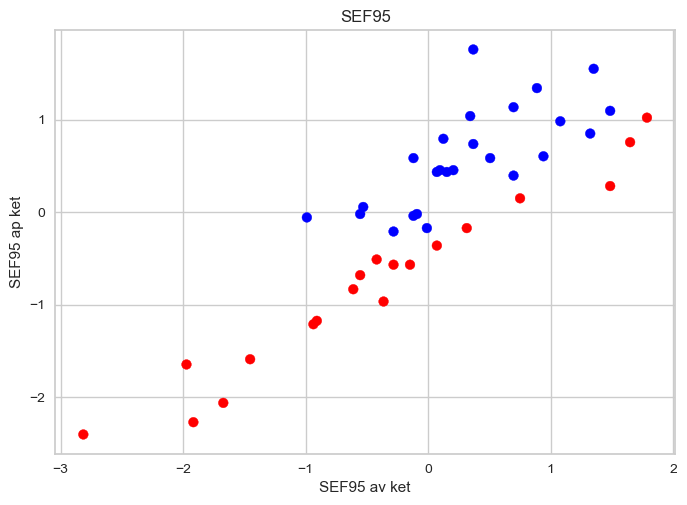

In [921]:
# Définir les couleurs pour les deux clusters
colors = np.array(['red', 'blue'])

# Tracer le nuage de points avec les couleurs personnalisées
plt.scatter(X['SEF95 av ket'], X['SEF95 ap ket'], c=colors[data_puissance["Reponse"]])
plt.xlabel('SEF95 av ket')
plt.ylabel('SEF95 ap ket')
plt.title('SEF95')
plt.show()

In [922]:
data_puissance_pos2 = data_puissance.loc[data_puissance['clusterSEF95'] == 1]
data_puissance_neg2 = data_puissance.loc[data_puissance['clusterSEF95'] == 0]

In [923]:
moyennes_puissances2 = pd.read_csv(r"C:\Users\nico_\Desktop\INSERM\Projet ICEO\moyennes_puissances2_csv.csv", sep=';', encoding='ISO-8859-1')

In [924]:
puissances_av = moyennes_puissances2.loc[0, ['P Delta av ket', 'P Thêta av ket', 'P Alpha av ket', 'P Bêta av ket', 'P Gamma av ket']]
puissances_ap = moyennes_puissances2.loc[0, ['P Delta ap ket', 'P Thêta ap ket', 'P Alpha ap ket', 'P Bêta ap ket', 'P Gamma ap ket']]

puissances_av_log10 = puissances_av.apply(lambda x: np.log10(x) if np.issubdtype(x.dtype, np.number) else x)
puissances_ap_log10 = puissances_ap.apply(lambda x: np.log10(x) if np.issubdtype(x.dtype, np.number) else x)

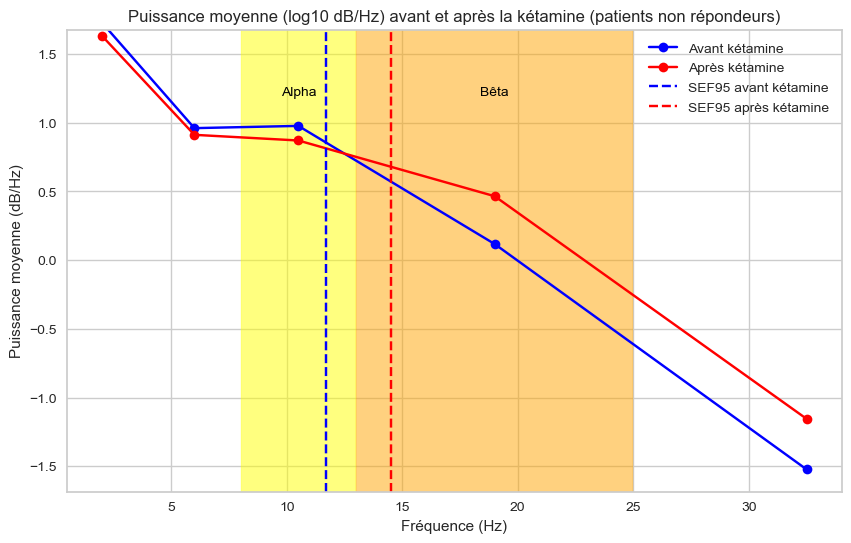

In [925]:
# Plages de fréquences pour chaque bande
bandes_frequences = ['Delta', 'Theta', 'Alpha', 'Bêta', 'Gamma']

# Fréquences centrales des bandes de fréquence
frequences_centrales = [2, 6, 10.5, 19, 32.5]

# Créer la figure et les axes
fig, ax = plt.subplots(figsize = (10,6))

# Tracer les courbes des puissances moyennes avant et après la kétamine
ax.plot(frequences_centrales, puissances_av_log10, color='blue', label='Avant kétamine', marker='o')
ax.plot(frequences_centrales, puissances_ap_log10, color='red', label='Après kétamine', marker='o')

# Identifier la bande alpha (8-13 Hz) avec une couleur jaune
alpha_start = 8.0
alpha_end = 13.0
ax.axvspan(alpha_start, alpha_end, alpha=0.5, color='yellow')

# Identifier la bande bêta (13-25 Hz) avec une couleur orange
beta_start = 13.0
beta_end = 25.0
ax.axvspan(beta_start, beta_end, alpha=0.5, color='orange')

# Moyennes SEF95:

sef95_freq_av = data_puissance["SEF95 av ket"].mean()
sef95_freq_ap = data_puissance["SEF95 ap ket"].mean()

# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Puissance moyenne (dB/Hz)')
ax.set_title('Puissance moyenne (log10 dB/Hz) avant et après la kétamine (patients non répondeurs)')

# Position des étiquettes des bandes en haut et au milieu de chaque bande
label_y = max(max(puissances_av_log10[2], puissances_ap_log10[2]), max(puissances_av_log10[3], puissances_ap_log10[3])) + 0.2

# Ajouter les étiquettes des bandes en haut et au milieu de chaque bande
for i, freq_centrale in enumerate(frequences_centrales[2:4], start=2):
    ax.text(freq_centrale, label_y, bandes_frequences[i], ha='center', va='bottom', color='black', fontsize=10)

# Ajuster la limite supérieure de l'axe y pour laisser de la place aux noms des bandes
ax.set_ylim(ax.get_ylim()[0], label_y + 0.5)

# Affichage SEF 95

ax.axvline(sef95_freq_av, color='blue', linestyle='--', label='SEF95 avant kétamine')
ax.axvline(sef95_freq_ap, color='red', linestyle='--', label='SEF95 après kétamine')

# Afficher la légende et la grille
ax.legend()
ax.grid(True)

# Afficher le graphique
plt.show()

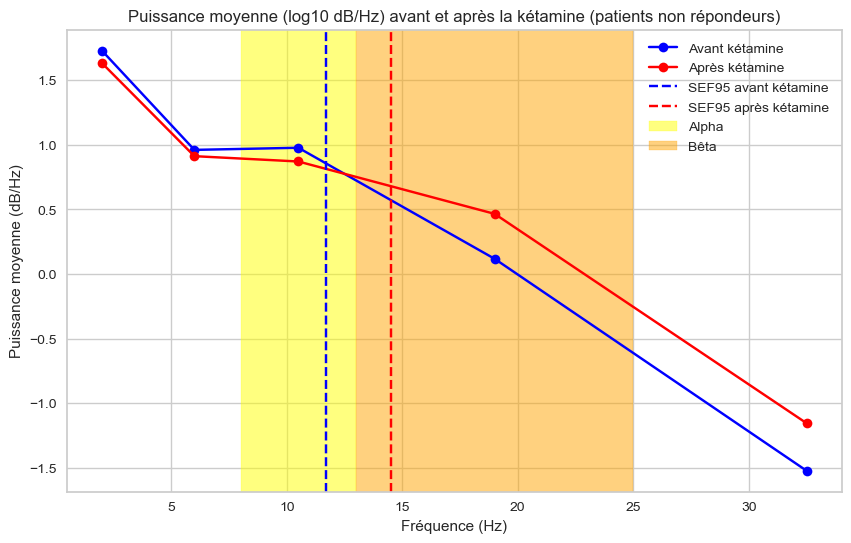

In [926]:
# Plages de fréquences pour chaque bande
bandes_frequences = ['Delta', 'Theta', 'Alpha', 'Bêta', 'Gamma']

# Fréquences centrales des bandes de fréquence
frequences_centrales = [2, 6, 10.5, 19, 32.5]

# Créer la figure et les axes
fig, ax = plt.subplots(figsize = (10,6))

# Tracer les courbes des puissances moyennes avant et après la kétamine
ax.plot(frequences_centrales, puissances_av_log10, color='blue', label='Avant kétamine', marker='o')
ax.plot(frequences_centrales, puissances_ap_log10, color='red', label='Après kétamine', marker='o')

# Moyennes SEF95:

sef95_freq_av = data_puissance["SEF95 av ket"].mean()
sef95_freq_ap = data_puissance["SEF95 ap ket"].mean()

# Affichage SEF 95

ax.axvline(sef95_freq_av, color='blue', linestyle='--', label='SEF95 avant kétamine')
ax.axvline(sef95_freq_ap, color='red', linestyle='--', label='SEF95 après kétamine')

# Identifier la bande alpha (8-13 Hz) avec une couleur jaune
alpha_start = 8.0
alpha_end = 13.0
ax.axvspan(alpha_start, alpha_end, alpha=0.5, color='yellow', label='Alpha')

# Identifier la bande bêta (13-25 Hz) avec une couleur orange
beta_start = 13.0
beta_end = 25.0
ax.axvspan(beta_start, beta_end, alpha=0.5, color='orange', label='Bêta')


# Définir les étiquettes des axes et le titre
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Puissance moyenne (dB/Hz)')
ax.set_title('Puissance moyenne (log10 dB/Hz) avant et après la kétamine (patients non répondeurs)')


# Afficher la légende et la grille
ax.legend()
ax.grid(True)

plt.show()

# Analyse P max Alpha Beta

In [928]:
data_Pmax = pd.read_csv(r"C:\Users\nico_\Desktop\INSERM\Projet ICEO\puissance alpha max csv.csv", sep=';', encoding='ISO-8859-1')

In [930]:
data_Pmax_merged = pd.merge(data_puissance, data_Pmax, on='Patient', how='inner')

# Heatmap

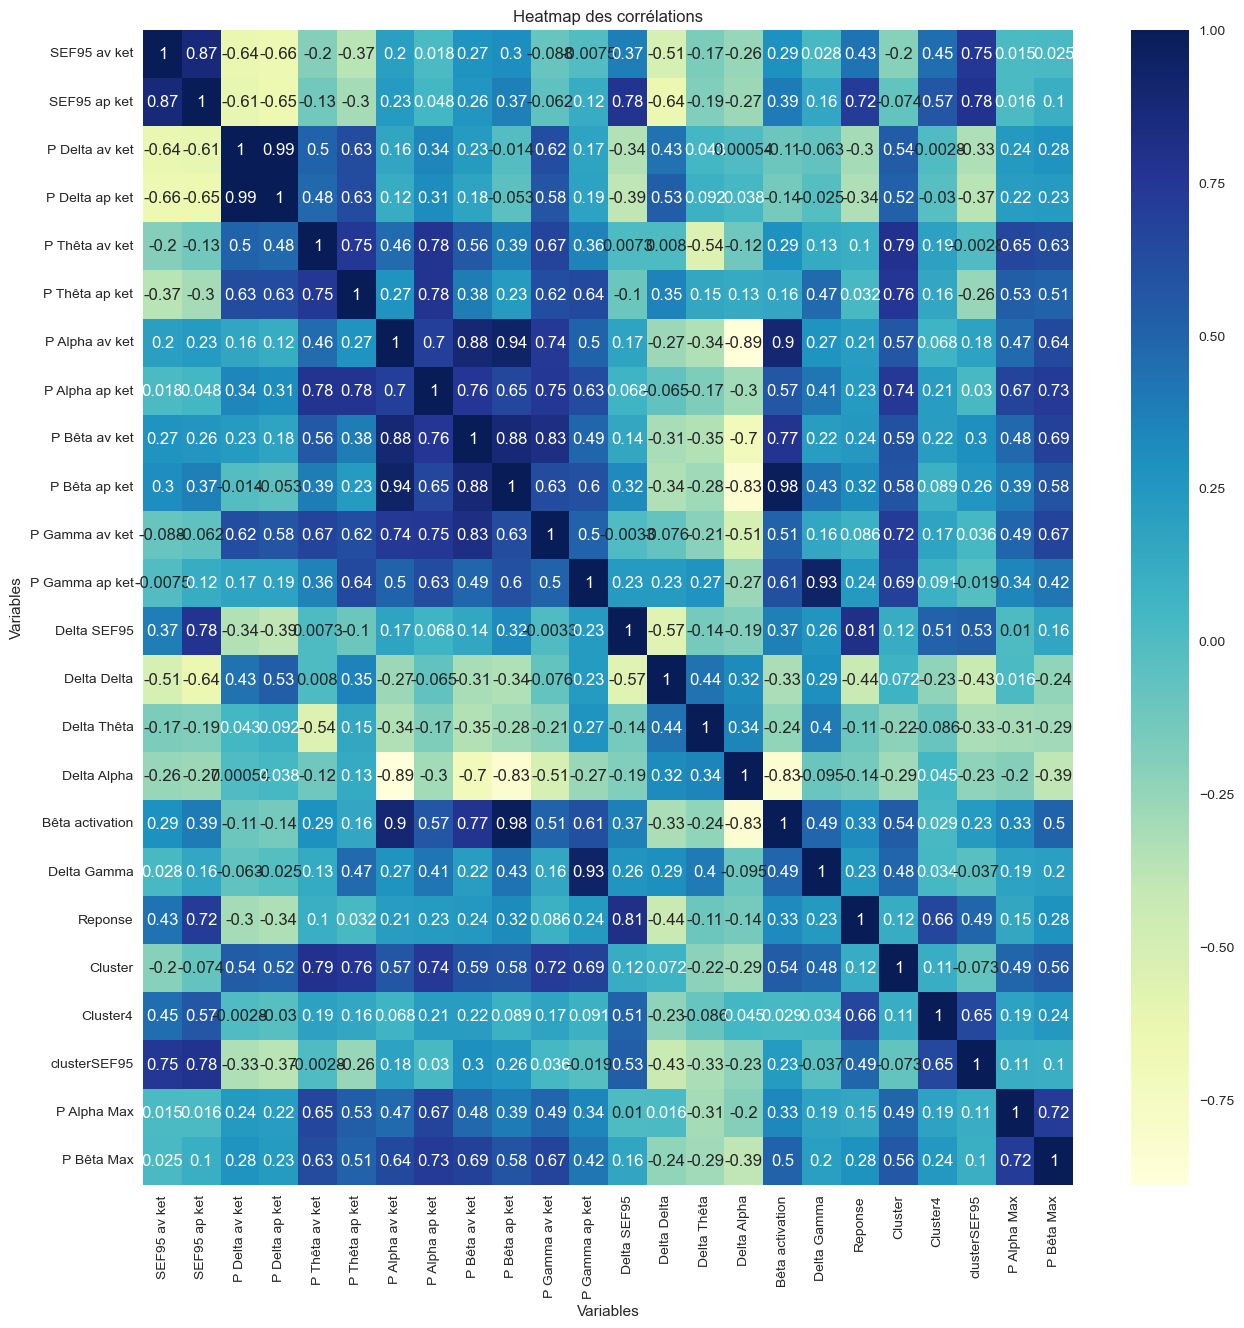

In [932]:
corr_matrix = data_Pmax_merged.corr()

plt.figure(figsize=(15, 15))

sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")

plt.title('Heatmap des corrélations')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()xw

# Droites de regression

P Alpha Max

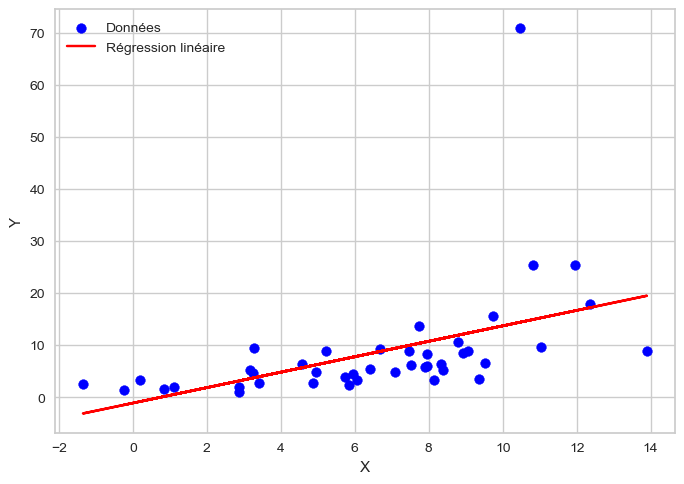

In [933]:
X = data_Pmax_merged["P Alpha Max"]
Y = data_Pmax_merged["P Alpha av ket"]

coefficients = np.polyfit(X, Y, 1)    # 1 : polynome de degré 1 dans la regression linéaire
slope = coefficients[0]
intercept = coefficients[1]

regression_line = slope * X + intercept

plt.scatter(X, Y, label='Données', color='blue')
plt.plot(X, regression_line, label='Régression linéaire', color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


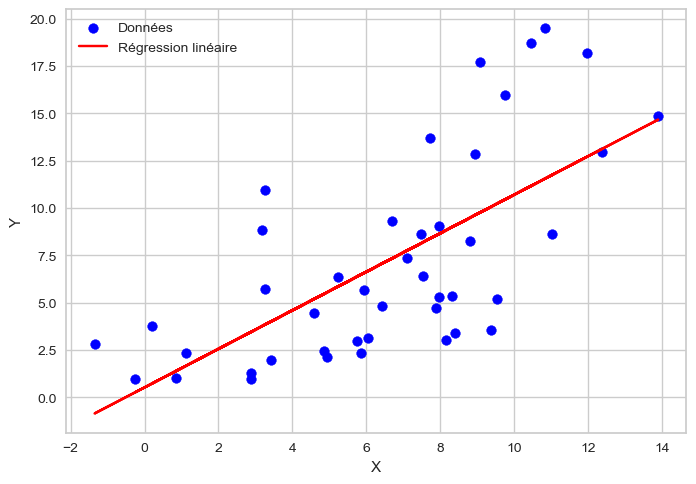

In [934]:
X = data_Pmax_merged["P Alpha Max"]
Y = data_Pmax_merged["P Alpha ap ket"]

coefficients = np.polyfit(X, Y, 1)    # 1 : polynome de degré 1 dans la regression linéaire
slope = coefficients[0]
intercept = coefficients[1]

regression_line = slope * X + intercept

plt.scatter(X, Y, label='Données', color='blue')
plt.plot(X, regression_line, label='Régression linéaire', color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

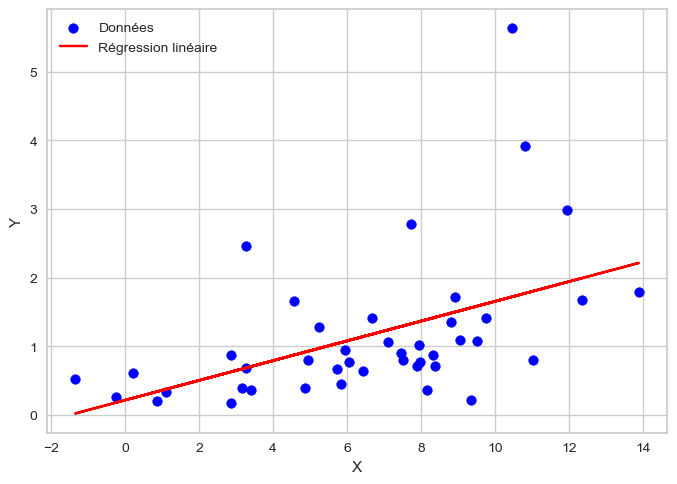

In [935]:
X = data_Pmax_merged["P Alpha Max"]
Y = data_Pmax_merged["P Bêta av ket"]

coefficients = np.polyfit(X, Y, 1)    # 1 : polynome de degré 1 dans la regression linéaire
slope = coefficients[0]
intercept = coefficients[1]

regression_line = slope * X + intercept

plt.scatter(X, Y, label='Données', color='blue')
plt.plot(X, regression_line, label='Régression linéaire', color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

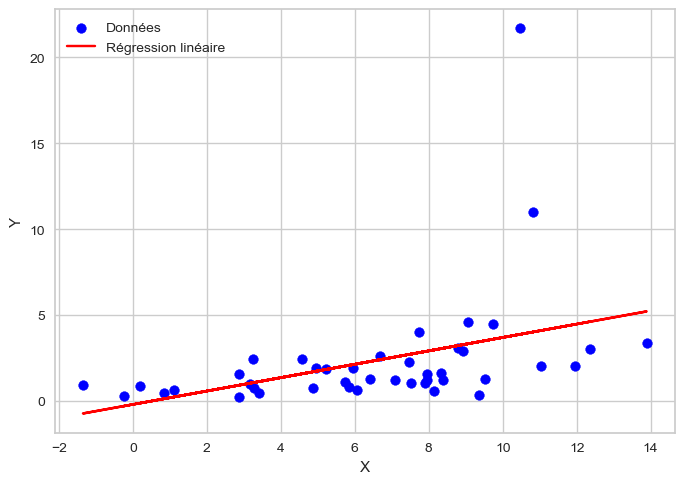

In [936]:
X = data_Pmax_merged["P Alpha Max"]
Y = data_Pmax_merged["P Bêta ap ket"]

coefficients = np.polyfit(X, Y, 1)    # 1 : polynome de degré 1 dans la regression linéaire
slope = coefficients[0]
intercept = coefficients[1]

regression_line = slope * X + intercept

plt.scatter(X, Y, label='Données', color='blue')
plt.plot(X, regression_line, label='Régression linéaire', color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

P Beta max

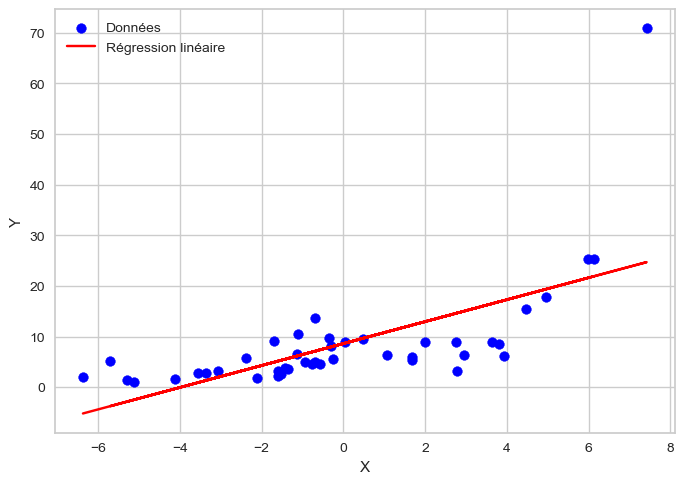

In [937]:
X = data_Pmax_merged["P Bêta Max"]
Y = data_Pmax_merged["P Alpha av ket"]

coefficients = np.polyfit(X, Y, 1)    # 1 : polynome de degré 1 dans la regression linéaire
slope = coefficients[0]
intercept = coefficients[1]

regression_line = slope * X + intercept

plt.scatter(X, Y, label='Données', color='blue')
plt.plot(X, regression_line, label='Régression linéaire', color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

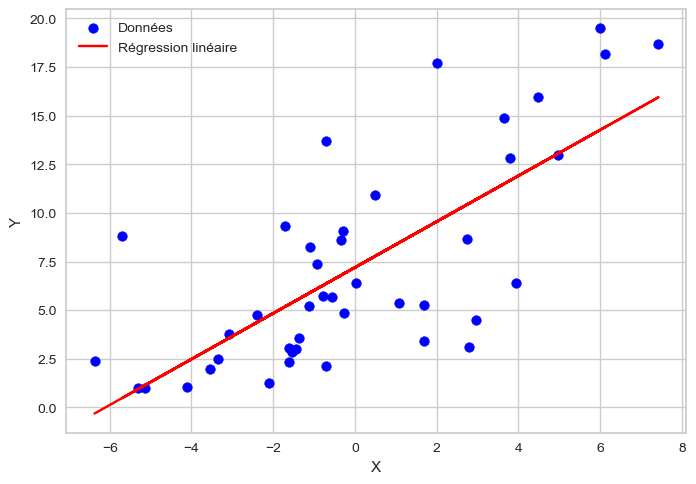

In [938]:
X = data_Pmax_merged["P Bêta Max"]
Y = data_Pmax_merged["P Alpha ap ket"]

coefficients = np.polyfit(X, Y, 1)    # 1 : polynome de degré 1 dans la regression linéaire
slope = coefficients[0]
intercept = coefficients[1]

regression_line = slope * X + intercept

plt.scatter(X, Y, label='Données', color='blue')
plt.plot(X, regression_line, label='Régression linéaire', color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

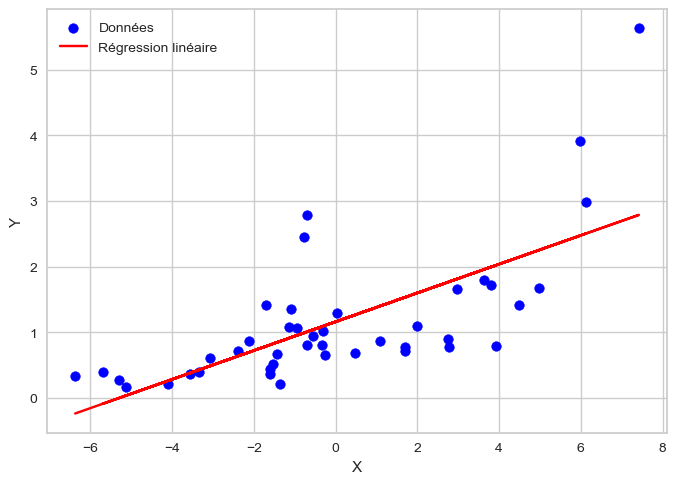

In [939]:
X = data_Pmax_merged["P Bêta Max"]
Y = data_Pmax_merged["P Bêta av ket"]

coefficients = np.polyfit(X, Y, 1)    # 1 : polynome de degré 1 dans la regression linéaire
slope = coefficients[0]
intercept = coefficients[1]

regression_line = slope * X + intercept

plt.scatter(X, Y, label='Données', color='blue')
plt.plot(X, regression_line, label='Régression linéaire', color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

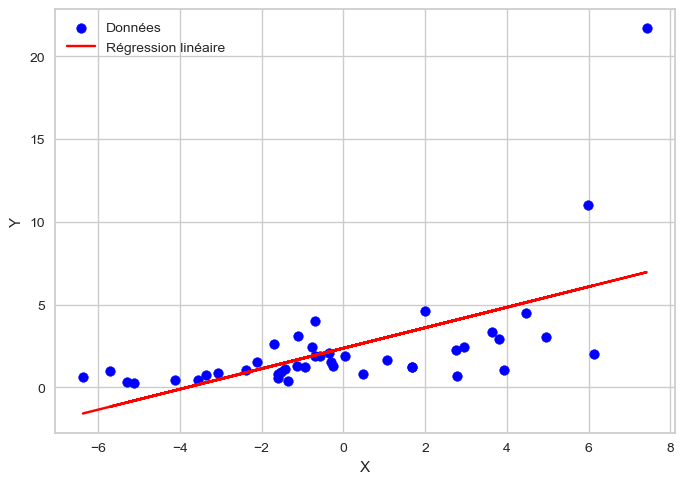

In [940]:
X = data_Pmax_merged["P Bêta Max"]
Y = data_Pmax_merged["P Bêta ap ket"]

coefficients = np.polyfit(X, Y, 1)    # 1 : polynome de degré 1 dans la regression linéaire
slope = coefficients[0]
intercept = coefficients[1]

regression_line = slope * X + intercept

plt.scatter(X, Y, label='Données', color='blue')
plt.plot(X, regression_line, label='Régression linéaire', color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [941]:
data_Pmax_merged['Reponse'] = data_Pmax_merged['Delta SEF95'].apply(lambda x: 0 if x < 2 else 1)

In [942]:
data_Pmax_merged_pos = data_Pmax_merged.loc[data_Pmax_merged["Reponse"] == 1]
data_Pmax_merged_neg = data_Pmax_merged.loc[data_Pmax_merged["Reponse"] == 0]

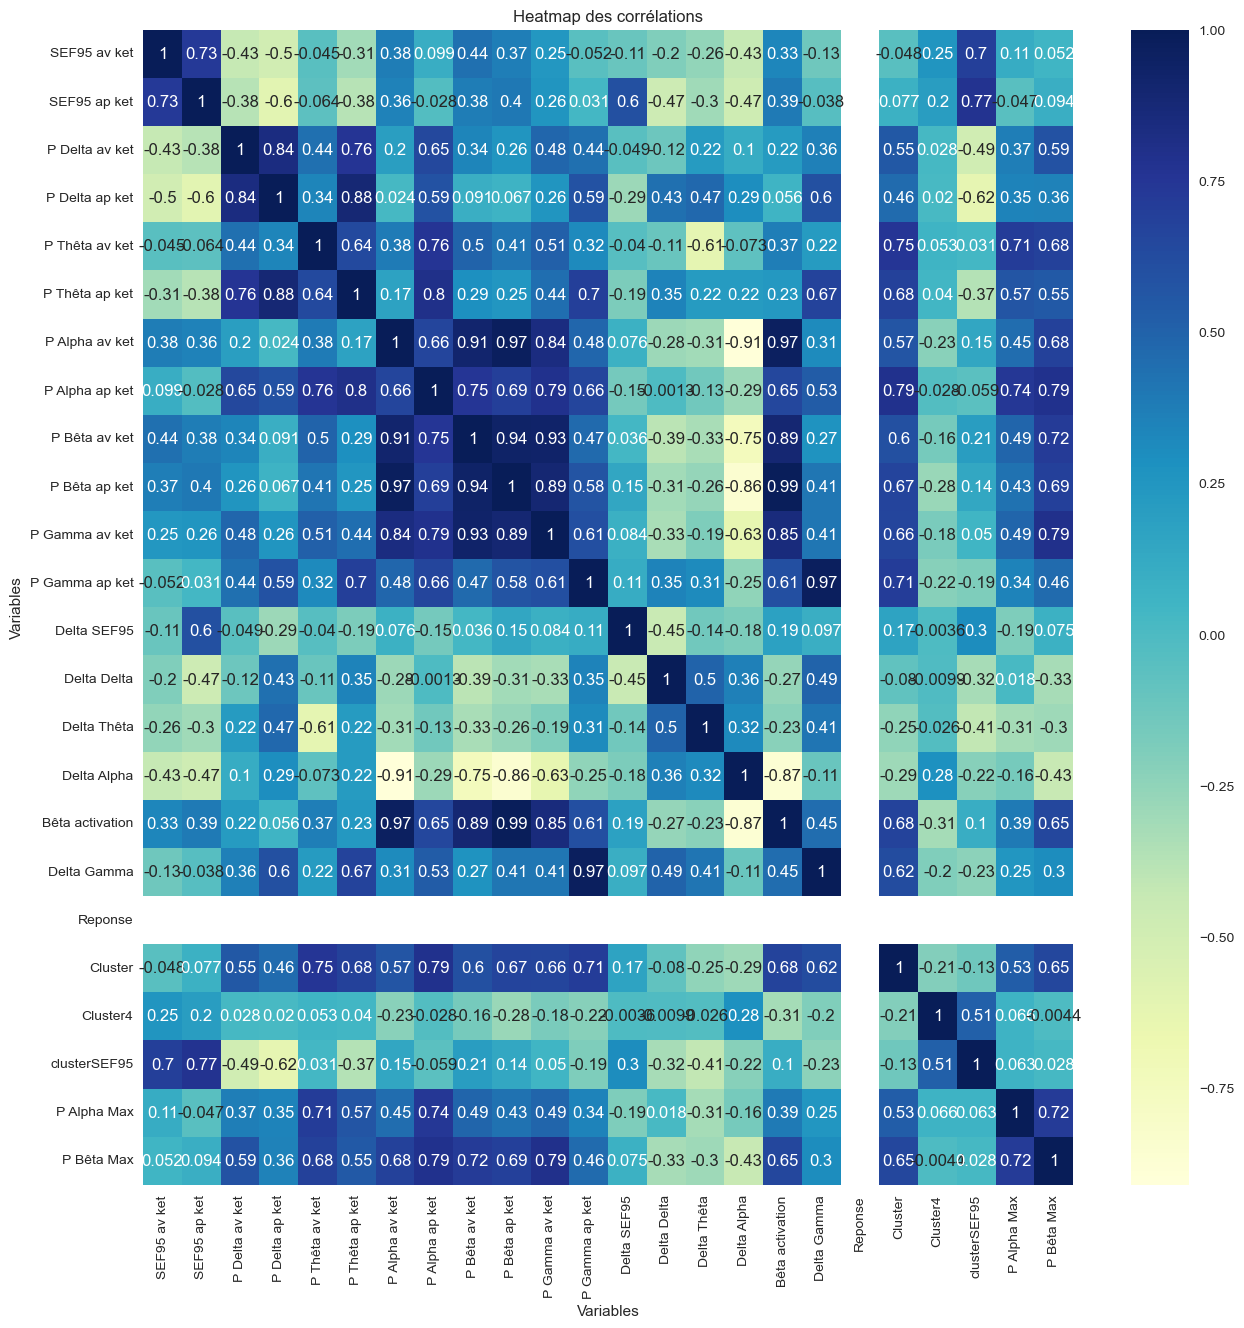

In [943]:
corr_matrix = data_Pmax_merged_pos.corr()

plt.figure(figsize=(15, 15))

sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")

plt.title('Heatmap des corrélations')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()

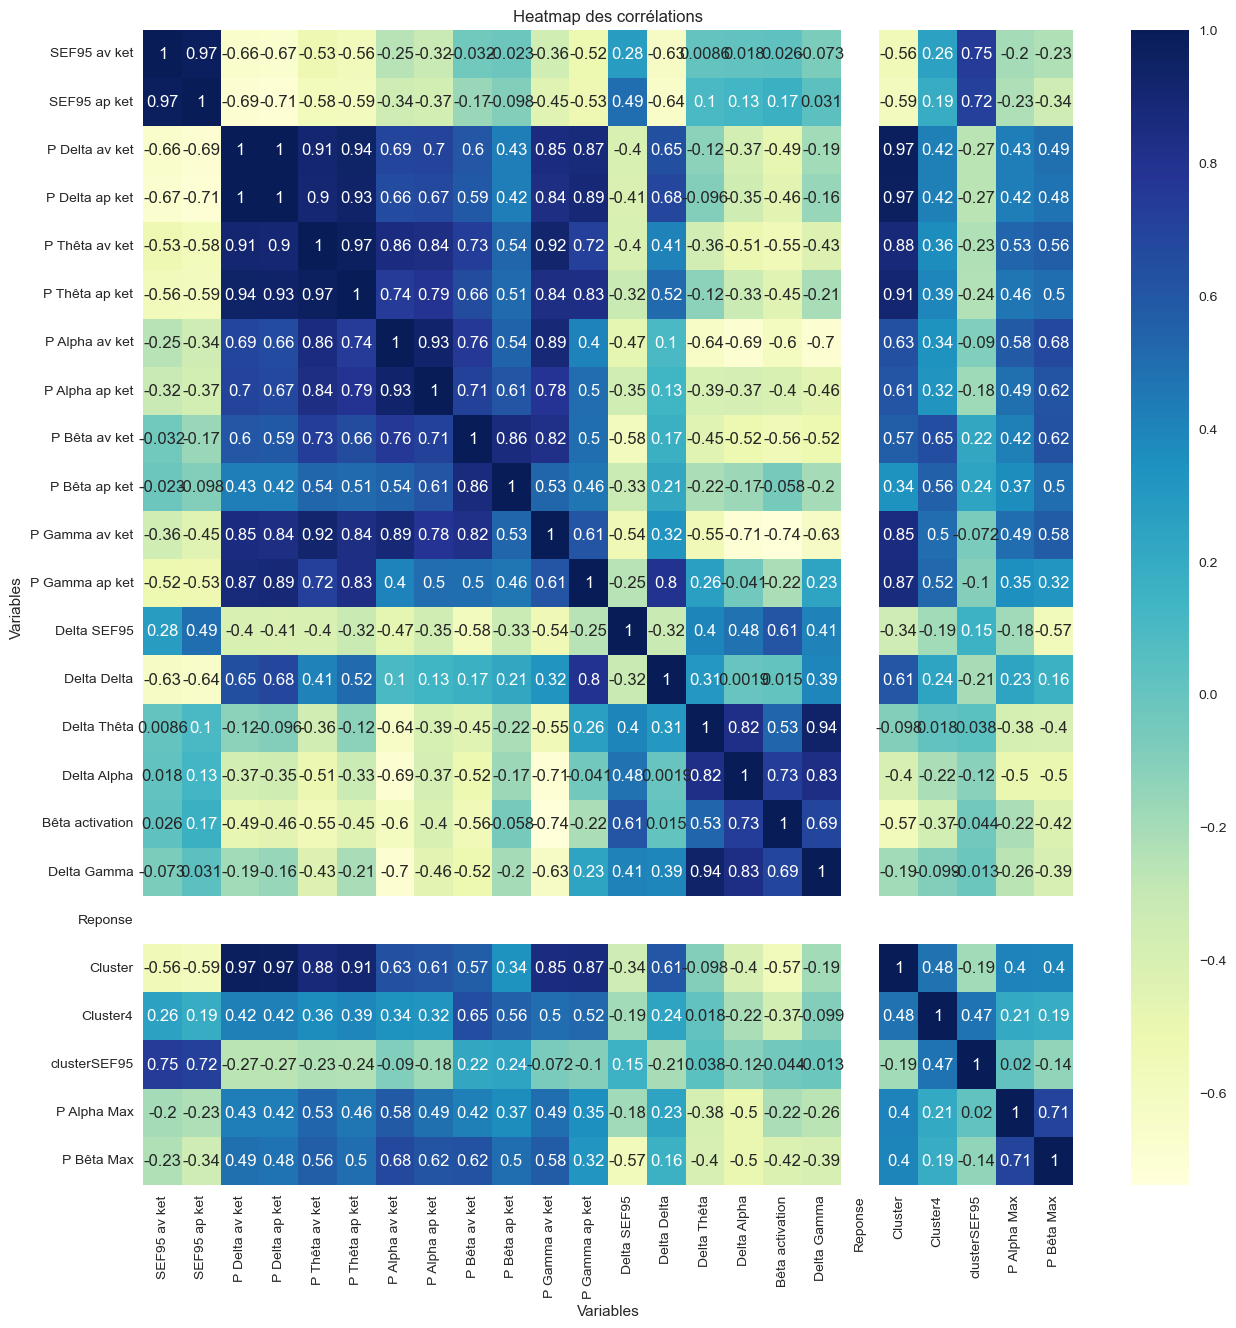

In [944]:
corr_matrix = data_Pmax_merged_neg.corr()

plt.figure(figsize=(15, 15))

sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")

plt.title('Heatmap des corrélations')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()